In [2]:
import scanpy as sc
import pandas as pd
import sys

In [2]:
import echidna as ec
import matplotlib.pyplot as plt
import torch
from scipy.stats import linregress
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from matplotlib.colors import ListedColormap
ec.pl.activate_plot_settings()

In [3]:
import numpy as np
import pandas as pd
from typing import Sequence, List, Dict, Any
from scipy.stats import pearsonr, spearmanr
from numpy.linalg import norm


def evaluate_regression_metrics(
    Xs: Sequence[np.ndarray],
    Ys: Sequence[np.ndarray],
    models: List[str],
    *,
    n_boot: int = 1_000,
    ci: float = 95,
    random_state: int = 0,
) -> pd.DataFrame:
    """
    For each (x, y) pair compute Pearson-r, Spearman-ρ, and cosine similarity
    with bootstrap CIs.  Returns DataFrame whose cells are
        (point_estimate, (ci_low, ci_high))
    """
    rng   = np.random.default_rng(random_state)
    alpha = (100 - ci) / 2           # 95 % ⇒ 2.5 / 97.5 percentiles
    rows: Dict[str, Dict[str, Any]] = {}

    for name, x, y in zip(models, Xs, Ys):
        x, y = x.ravel(), y.ravel()
        n    = x.size

        # ---------- point estimates ----------
        pearson_val  = pearsonr(x, y).statistic
        spearman_val = spearmanr(x, y).correlation
        cos_val      = float(np.dot(x, y) / (norm(x) * norm(y)))

        # ---------- bootstrap ----------
        p_dist, s_dist, c_dist = [], [], []
        for _ in range(n_boot):
            idx        = rng.choice(n, n, replace=True)
            xb, yb     = x[idx], y[idx]
            p_dist.append(pearsonr(xb, yb).statistic)
            s_dist.append(spearmanr(xb, yb).correlation)
            c_dist.append(float(np.dot(xb, yb) / (norm(xb) * norm(yb))))

        def ci_bounds(dist):
            return np.percentile(dist, [alpha, 100 - alpha])

        pear_lo,  pear_hi  = ci_bounds(p_dist)
        spear_lo, spear_hi = ci_bounds(s_dist)

        # ---------- assemble ----------
        rows[name] = {
            "PearsonR":   (pearson_val,  (pear_lo,  pear_hi)),
            "SpearmanR":  (spearman_val, (spear_lo, spear_hi))
        }

    return pd.DataFrame.from_dict(rows, orient="index")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# ------------------------------------------------------------------ #
# colour map (extend if you add more tools)
# ------------------------------------------------------------------ #
_COLOR_MAP = {
    "echidna":   plt.cm.tab10.colors[0],
    "inferCNV":  plt.cm.tab10.colors[1],
    "numbat":    plt.cm.tab10.colors[2],
    "CopyKAT":   plt.cm.tab10.colors[3],
    "XClone":    plt.cm.tab10.colors[4],
}

def _star(p):
    if p < 1e-10: return '***'
    if p < 1e-5:  return '**'
    if p < 0.05:  return '*'
    return ''

def plot_metric_bar(
    ax,
    metric: str,
    data,                     # DataFrame from evaluate_regression_metrics
    orientation: str = "vertical",
    capsize: int = 4,
):
    """
    Plot `metric` for every model in `data`.

    Each cell in `data` is (mean, (ci_low, ci_high)).
    Bars are sorted high→low, coloured via `_COLOR_MAP`,
    and model names appear on the axis ticks (no legend).
    """

    # -------- gather --------------------------------------------------------
    tools      = list(data.index)
    means, err_low, err_high = [], [], []

    for t in tools:
        mean, (lo, hi) = data.loc[t, metric]
        means.append(mean)
        err_low.append(mean - lo)
        err_high.append(hi - mean)

    order      = np.argsort(means)[::-1]            # best → worst
    means      = [means[i]      for i in order]
    err_low    = [err_low[i]    for i in order]
    err_high   = [err_high[i]   for i in order]
    labels     = [tools[i]      for i in order]
    colours    = [_COLOR_MAP.get(l, "grey") for l in labels]

    # -------- draw ----------------------------------------------------------
    if orientation == "horizontal":
        y_pos = np.arange(len(labels))
        for j in range(len(labels)):
            ax.barh(
                y_pos[j],
                means[j],
                xerr=[[err_low[j]], [err_high[j]]],
                color=colours[j],
                alpha=0.85,
                capsize=capsize,
            )

        # method names on y‑axis
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels, fontsize=14)
        ax.tick_params(axis="y", labelsize=14)      # enlarge y‑tick labels
        ax.set_xlabel(metric, fontsize=20)
        ax.grid(axis="x", linestyle="--", alpha=0.4)

        # significance stars (vs. top bar)
        ref = np.random.normal(means[0], np.mean([err_low[0], err_high[0]]), 500)
        for j in range(1, len(labels)):
            comp  = np.random.normal(
                means[j], np.mean([err_low[j], err_high[j]]), 500
            )
            star  = _star(ttest_ind(ref, comp).pvalue)
            if star:
                ax.text(
                    means[j] + err_high[j] + 0.02 * max(means),
                    y_pos[j],
                    star,
                    va="center",
                    fontsize=12,
                )

    else:  # vertical
        x_pos = np.arange(len(labels))
        for j in range(len(labels)):
            ax.bar(
                x_pos[j],
                means[j],
                yerr=[[err_low[j]], [err_high[j]]],
                color=colours[j],
                alpha=0.85,
                capsize=capsize,
            )

        # method names on x‑axis
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, fontsize=18, rotation=90)
        ax.set_ylabel(metric, fontsize=20)
        ax.tick_params(axis="y", labelsize=18)      # enlarge y‑axis numbers
        ax.grid(axis="y", linestyle="--", alpha=0.4)

        ref   = np.random.normal(means[0], np.mean([err_low[0], err_high[0]]), 500)
        for j in range(1, len(labels)):
            comp = np.random.normal(
                means[j], np.mean([err_low[j], err_high[j]]), 500
            )
            star = _star(ttest_ind(ref, comp).pvalue)
            if star:
                ax.text(
                    x_pos[j],
                    means[j] + err_high[j] + 0.02 * max(means),
                    star,
                    ha="center",
                    fontsize=11,
                )

In [5]:
from echidna.tools.infer_gd import _get_neutral_state
from hmmlearn import hmm

In [6]:
def run_HMM(
    vals: np.ndarray,
    n_components: int=5,
    neutral_mean: float=2.0,
    neutral_std: float=1.0,
    transmat_prior: float=1.0,
    startprob_prior: float=1.0,
    n_iter: int=100,
    verbose: bool=False,
    stderr_scaler: float=1.96,
    shift: bool=True
):

    scores = []
    models = []

    idx = np.random.choice(range(100), size=10)
    for i in range(10):
        model = hmm.GaussianHMM(
            n_components=n_components,
            random_state=idx[i],
            n_iter=n_iter,
            transmat_prior=transmat_prior,
            startprob_prior=startprob_prior,
            tol=0.01
        )
        model.fit(vals.reshape(-1, 1))
        models.append(model)
        scores.append(model.score(vals.reshape(-1, 1)))

    # Get the best model
    model = models[np.argmax(scores)]

    states = model.predict(vals[:, None])

    tmp = pd.DataFrame({"vals": vals, "states": states})
    state_dict = tmp.groupby("states")["vals"].mean().reset_index()

    n_stddevs = stderr_scaler

    state_dict["neutral"] = abs(state_dict["vals"] - neutral_mean) <= n_stddevs * neutral_std
    state_dict["amp"] = state_dict["vals"] - neutral_mean > n_stddevs * neutral_std
    state_dict["del"] = state_dict["vals"] - neutral_mean < -n_stddevs * neutral_std

    def classify_state(row):
        if row["neutral"] is True:
            return "neut"
        elif row["amp"] is True:
            return "amp"
        elif row["del"] is True:
            return "del"
    state_dict["CNV"] = state_dict.apply(classify_state, axis=1)
    state_map = state_dict.set_index("states")["CNV"].to_dict()
    cnvs = [state_map[s] for s in states]

    return cnvs

In [7]:
def predict_states_with_binned_cnv(X, clusters, plot_gmm=True, n_comp=5, n_comp_hmm=5,
                                   n_iter=100, shift=True, scale=1.96, gmm_base=True):
    states_df = pd.DataFrame()
    X = np.array(X).T
    if gmm_base:
      neut_ = _get_neutral_state(X, clusters, plot_gmm=plot_gmm, n_components=n_comp, neut_method="count_mode")
    for c in clusters:
      if gmm_base:
        state = run_HMM(X[:, c], n_components=n_comp_hmm,
                          neutral_mean=neut_.loc[c]['neutral_value_mean'],
                          neutral_std=neut_.loc[c]['neutral_value_std'],
                          n_iter=n_iter,
                          stderr_scaler=scale)
        states_df[c] = state
        if shift:
          X[:, c] -= neut_.loc[c]['neutral_value_mean']

    return states_df.T, X

In [8]:
def compute_precision_recall_tpr_fpr(true_labels, predicted_labels):
    precisions = []
    recalls = []
    tprs = []
    fprs = []

    for trow, prow in zip(true_labels, predicted_labels):
        # Identify positions of interest
        non_neut_true = [i for i, lbl in enumerate(trow) if lbl != 'neut']
        non_neut_pred = [i for i, lbl in enumerate(prow) if lbl != 'neut']

        # Count true positives:
        # For precision/recall we considered TP as exact matches of non-neut classes.
        true_positives = sum(trow[i] == prow[i] and trow[i] != 'neut' for i in range(len(trow)))

        # Number of actual positives (non-neut in true)
        actual_positives = len(non_neut_true)

        # Number of predicted positives (non-neut in predicted)
        predicted_positives = len(non_neut_pred)

        # Precision and Recall
        if actual_positives == 0:
            # No actual positives
            recall = 0.0
            # If there are no predicted positives either, precision = 0.0 by definition
            precision = 0.0
        else:
            recall = true_positives / actual_positives
            precision = true_positives / predicted_positives if predicted_positives > 0 else 0.0

        precisions.append(precision)
        recalls.append(recall)

        # Compute TPR and FPR
        # Define positives and negatives:
        # Positive: label != 'neut'
        # Negative: label == 'neut'

        # Count TP, FP, FN, TN for binary classification interpretation
        TP = sum((t != 'neut' and p != 'neut') for t, p in zip(trow, prow))
        FN = sum((t != 'neut' and p == 'neut') for t, p in zip(trow, prow))
        FP = sum((t == 'neut' and p != 'neut') for t, p in zip(trow, prow))
        TN = sum((t == 'neut' and p == 'neut') for t, p in zip(trow, prow))

        # TPR = TP / (TP + FN) if TP+FN > 0 else 0
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0

        # FPR = FP / (FP + TN) if FP+TN > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0

        tprs.append(TPR)
        fprs.append(FPR)

    return np.array(precisions), np.array(recalls), np.array(tprs), np.array(fprs)

In [9]:
def get_binned_DNA_orig(adata, DNA, map, eta):
  barcodes = list(adata.obs_names)
  for i in range(len(barcodes)):
    barcodes[i] = barcodes[i].split("_")[0]
  barcodes_overlap = set(barcodes).intersection(set(DNA.columns))

  DNA = DNA[barcodes]
  DNA = DNA / np.array(DNA).mean(axis=0) * 2 # THIS STEP IS DESCRIBED IN THE PUBLISHED PAPER THIS DATA CAME FROM


  eta_df = pd.DataFrame(eta.cpu().detach().numpy())
  eta_df.columns = adata.var_names

  DNA_clus = pd.DataFrame()
  for cluster in eta_df.index:
    DNA_cluster = []
    obs = adata.obs
    for i in range(len(obs['leiden'].unique())):
        inds = obs[obs["leiden"]==str(i)].index
        inds = [i.split("_")[0] for i in inds]
        DNA_cluster.append(list(DNA[inds].mean(axis=1)))

    DNA_cluster = pd.DataFrame(DNA_cluster)

    gene_names = []
    W1 = []
    for i in range(DNA_cluster.shape[1]):
        genes = str.split(map.iloc[i]["genes"],",")
        gene_names+=genes
        W1+=[DNA_cluster.loc[cluster][i] for j in range(len(genes))]

    DNA_clus[cluster] =  W1
  DNA_clus.index = gene_names
  return DNA_clus, DNA_cluster

In [10]:
# helper function for binning
def binning_eta(df):
    binned = []
    discard_bins = []
    for id, row in map.iterrows():
        genes = str.split(row['genes'],",")
        overlap = list(set(df.columns).intersection(set(genes)))
        in_bin = df[overlap]
        if np.array(in_bin).shape[1] == 0:
            discard_bins.append(id)
            continue
        bin_col = np.array(in_bin).mean(axis=1)
        binned.append(bin_col.reshape(-1, 1))
    binned = np.concatenate(binned, axis=1)
    return binned, discard_bins

# CNA Reconstruction

In [11]:
import pandas as pd

In [12]:
echi_binned = np.load("/home/mingxuanzhang/echidna/benchmarking_data/echidna_binned_tumor2.npy")
infercnv_binned = np.load("/home/mingxuanzhang/echidna/benchmarking_data/infercnv_binned_tumor2.npy")
numbat_binned = np.load("/home/mingxuanzhang/echidna/benchmarking_data/numbat_binned_tumor2.npy")
copykat_binned = np.load("/home/mingxuanzhang/echidna/benchmarking_data/copykat_binned_tumor2.npy")
xclone_binned = np.load("/home/mingxuanzhang/echidna/benchmarking_data/xclone_binned_tumor2.npy")

In [13]:
dna_infercnv = np.array(pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_infercnv_tumor2.csv", index_col=0))
dna_numbat = np.array(pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_numbat_tumor2.csv", index_col=0))

In [14]:
dna_echidna = np.load("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_echidna_tumor2.npy")
dna_copykat = np.load("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_copykat_tumor2.npy")
dna_xclone = np.load("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_xclone_tumor2.npy")

In [16]:
mapp = pd.read_csv("data/bin-boundaries and genes.txt", sep="\t")
mapp

,chr,start,stop,abspos,length,gc,n_good,genes
0,chr1,0,14162233,7081116,14162233,0.485181,213318,"MIR7846,ERRFI1,PRAMEF10,PLOD1,UBE2J2,C1orf127,..."
1,chr1,14162233,27382184,20772208,13219951,0.473007,213318,"DHDDS-AS1,MIR6084,CD52,IFFO2,PINK1-AS,CTRC,LYP..."
2,chr1,27382184,38550236,32966210,11168052,0.470651,213319,"SYTL1,ADPRS,MIR5585,A3GALT2,EVA1B,MIR5581,GJB4..."
3,chr1,38550236,55768724,47159480,17218488,0.451368,213319,"MIR30E,HECTD3,LINC01398,PCSK9,RNF11,PARS2,MIR5..."
4,chr1,55768724,67940820,61854772,12172096,0.408516,213318,"CYP2J2,TM2D1,PGM1,SLC35D1,DAB1-AS1,OMA1,MIR606..."
...,...,...,...,...,...,...,...,...
295,chrX,119113350,126114914,3003647418,7001564,0.376393,213856,"GRIA3,SH2D1A,RHOXF2,RHOXF1,XIAP,MIR3672,CT47A1..."
296,chrX,126114914,134090813,3011136149,7975899,0.389447,213855,"OCRL,FAM122B,ENOX2,USP26,IGSF1,OR13H1,FIRRE,MO..."
297,chrX,134090813,141191109,3018674247,7100296,0.396227,213855,"CT45A9,CT45A8,SMIM10,CD40LG,LOC100506790,CT45A..."
298,chrX,141191109,146142467,3024700074,4951358,0.371499,213855,"SPANXN4,SLITRK4,SPANXN1,MIR888,SPANXN3,SPANXN2..."


In [18]:
mapp['bin_index'] = mapp.index
mapp

,chr,start,stop,abspos,length,gc,n_good,genes,bin_index
0,chr1,0,14162233,7081116,14162233,0.485181,213318,"MIR7846,ERRFI1,PRAMEF10,PLOD1,UBE2J2,C1orf127,...",0
1,chr1,14162233,27382184,20772208,13219951,0.473007,213318,"DHDDS-AS1,MIR6084,CD52,IFFO2,PINK1-AS,CTRC,LYP...",1
2,chr1,27382184,38550236,32966210,11168052,0.470651,213319,"SYTL1,ADPRS,MIR5585,A3GALT2,EVA1B,MIR5581,GJB4...",2
3,chr1,38550236,55768724,47159480,17218488,0.451368,213319,"MIR30E,HECTD3,LINC01398,PCSK9,RNF11,PARS2,MIR5...",3
4,chr1,55768724,67940820,61854772,12172096,0.408516,213318,"CYP2J2,TM2D1,PGM1,SLC35D1,DAB1-AS1,OMA1,MIR606...",4
...,...,...,...,...,...,...,...,...,...
295,chrX,119113350,126114914,3003647418,7001564,0.376393,213856,"GRIA3,SH2D1A,RHOXF2,RHOXF1,XIAP,MIR3672,CT47A1...",295
296,chrX,126114914,134090813,3011136149,7975899,0.389447,213855,"OCRL,FAM122B,ENOX2,USP26,IGSF1,OR13H1,FIRRE,MO...",296
297,chrX,134090813,141191109,3018674247,7100296,0.396227,213855,"CT45A9,CT45A8,SMIM10,CD40LG,LOC100506790,CT45A...",297
298,chrX,141191109,146142467,3024700074,4951358,0.371499,213855,"SPANXN4,SLITRK4,SPANXN1,MIR888,SPANXN3,SPANXN2...",298


In [19]:
chr_groups = mapp.groupby('chr')['bin_index'].agg(['min', 'max']).reset_index()
chr_groups.head()

,chr,min,max
0,chr1,0,20
1,chr10,170,182
2,chr11,183,195
3,chr12,196,208
4,chr13,209,220


2025-07-25 20:48:41,379 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,380 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,381 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,383 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,383 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,384 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,385 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,386 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,387 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,388 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,390 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:41,392 | WARNING : findfon

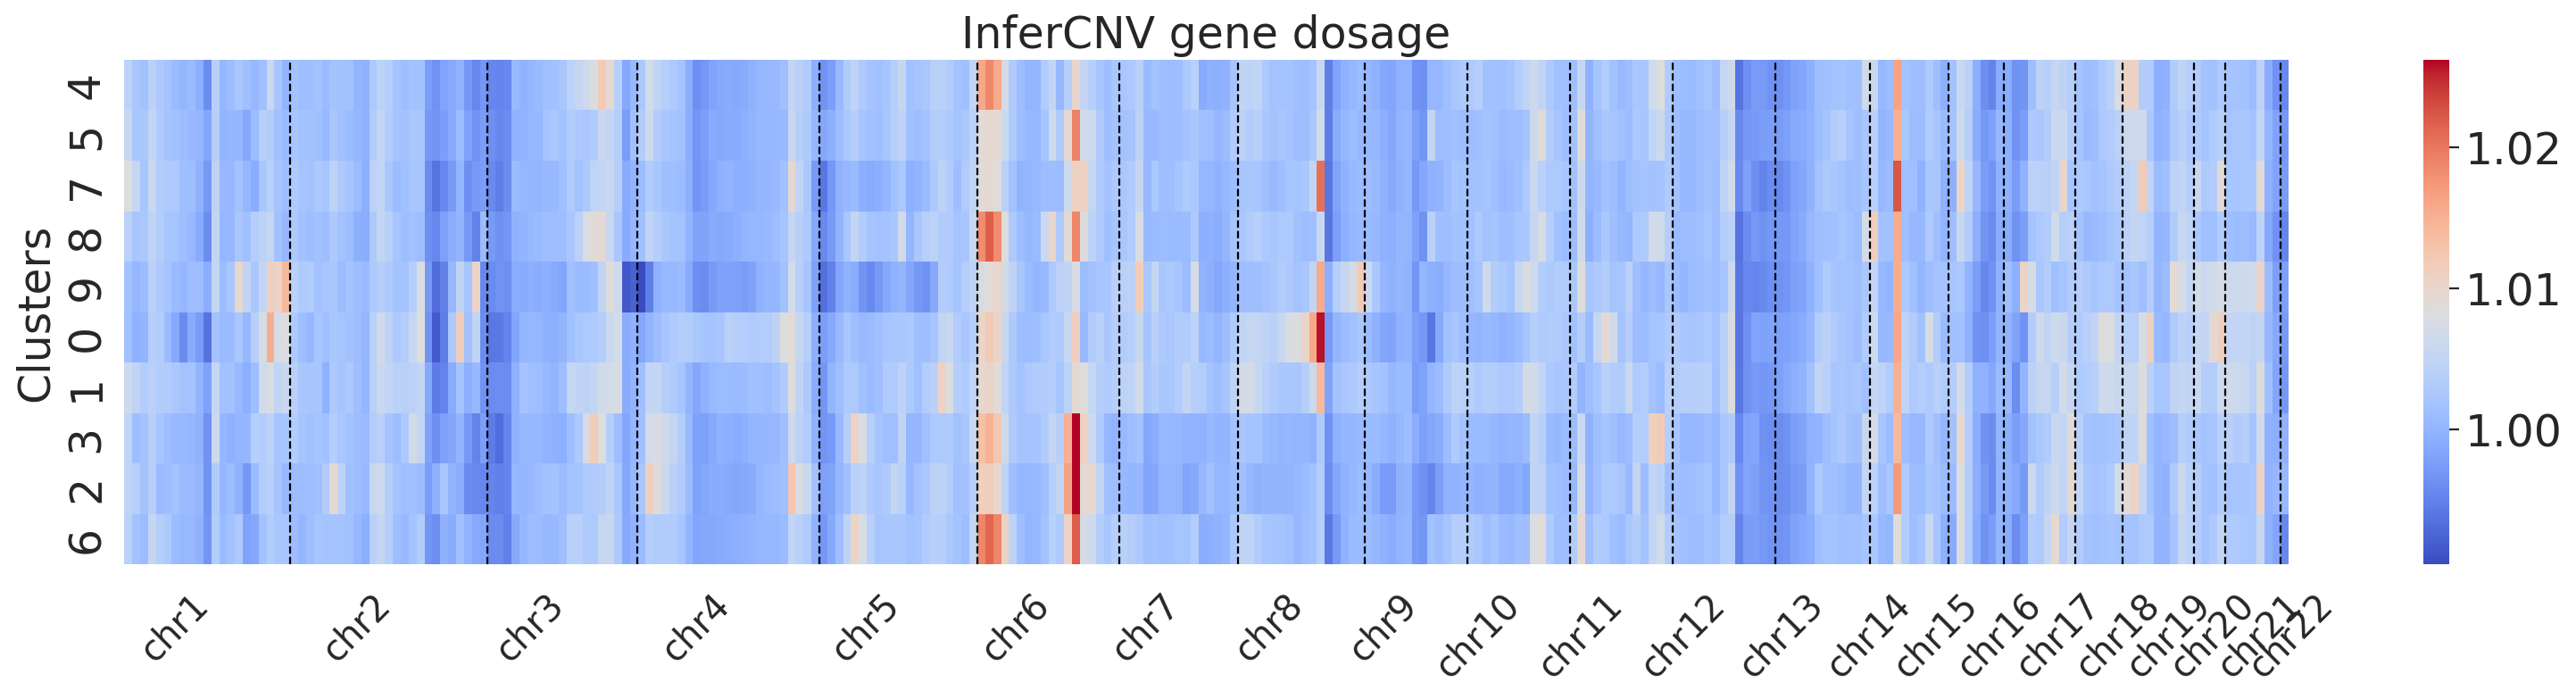

In [27]:
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Sans'
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=1)
sns.heatmap(infercnv_binned, cmap="coolwarm", ax=ax,  xticklabels=False, cbar=True)

# Draw dashed lines at chromosome boundaries
for i in chr_groups.index[:-1]:
    boundary = chr_groups.loc[i, 'max'] + 1
    ax.axvline(x=boundary, color='black', linestyle='--', linewidth=1)

x_min, x_max = ax.get_xlim()

for i, row in chr_groups.iterrows():
    if row['chr'] == 'chrX':
        continue
    midpoint = (row['min'] + row['max']) / 2.0
    ax.text(
        midpoint,
        -0.07,
        row['chr'],
        ha='right',
        va='center',
        rotation=45,
        rotation_mode='anchor',
        fontsize=18,
        transform=ax.get_xaxis_transform()
    )

# Set labels and titles
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)

row_order = [4, 5, 7, 8, 9, 0, 1, 3, 2, 6] # make consistent with figure 2
ax.set_yticklabels(row_order, fontsize=22)
ax.set_ylabel("Clusters", fontsize=22)
ax.set_title("InferCNV gene dosage", fontsize=22)

plt.tight_layout()
plt.savefig("infercnv_tumor2.svg", format='svg')
plt.show()

2025-07-25 20:48:20,780 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,782 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,783 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,785 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,786 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,788 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,789 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,790 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,791 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,793 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,794 | WARNING : findfont: Font family 'Liberation Sans' not found.
2025-07-25 20:48:20,796 | WARNING : findfon

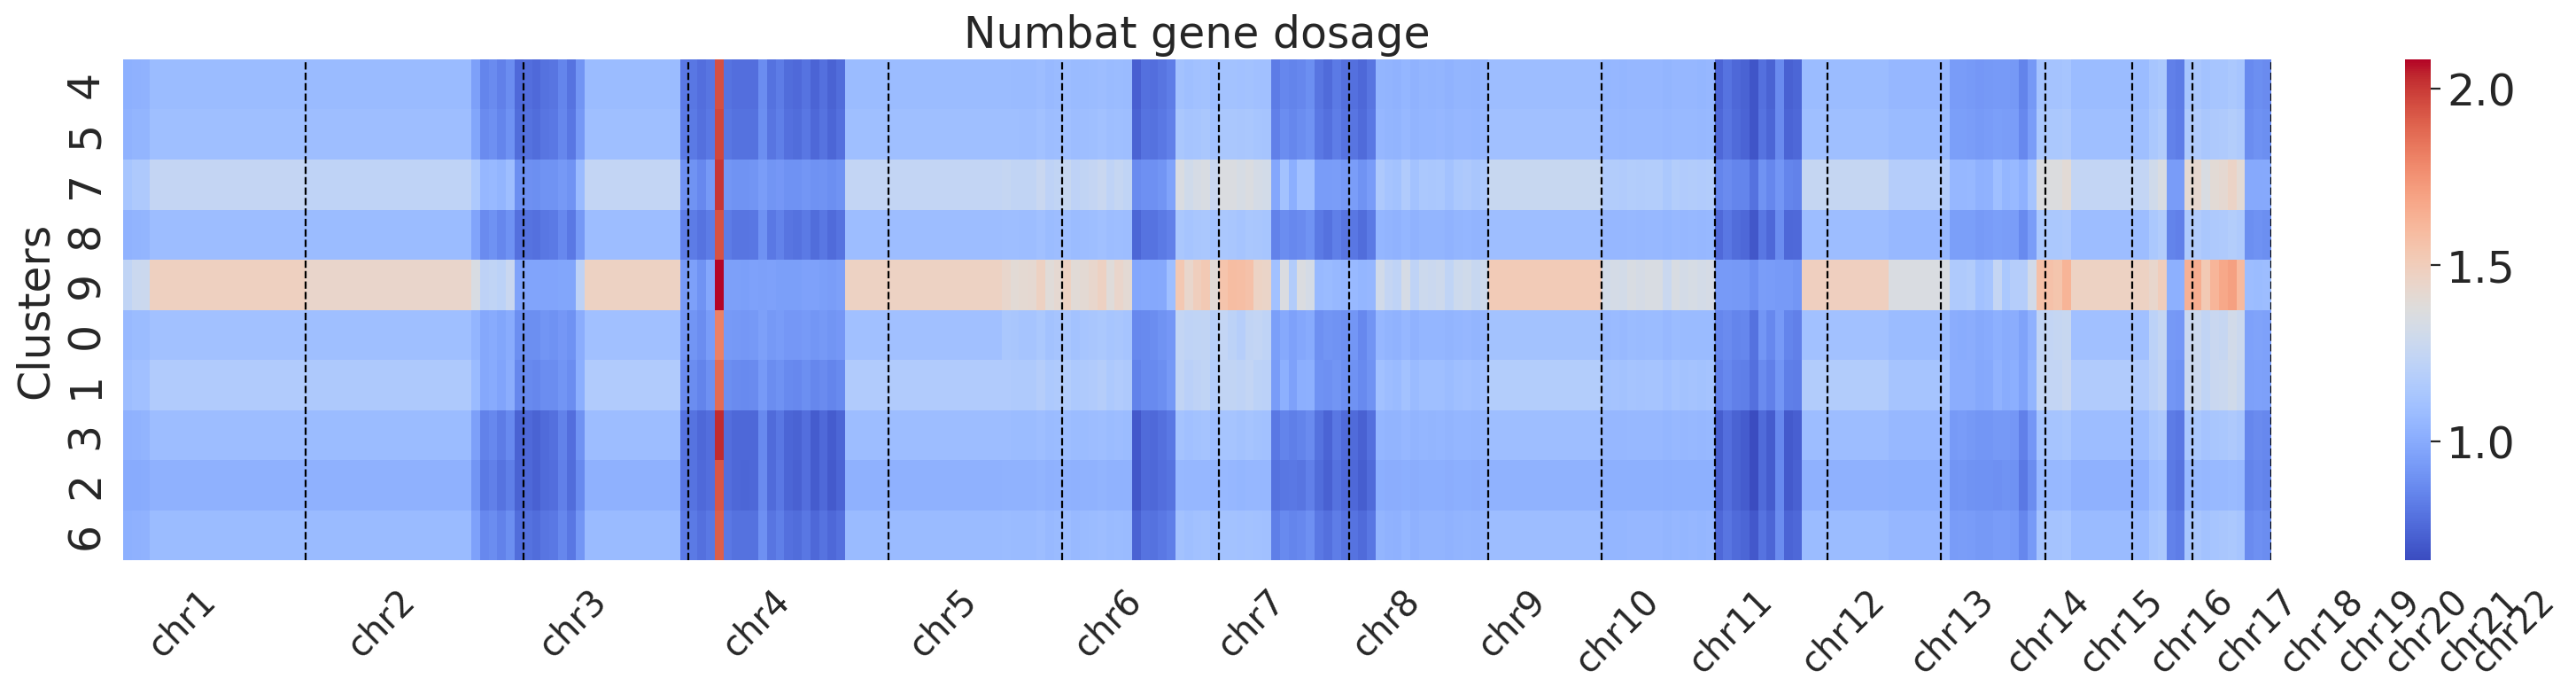

In [26]:
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Sans'
fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=1)
sns.heatmap(numbat_binned, cmap="coolwarm", ax=ax,  xticklabels=False, cbar=True)

# Draw dashed lines at chromosome boundaries
for i in chr_groups.index[:-1]:
    boundary = chr_groups.loc[i, 'max'] + 1
    ax.axvline(x=boundary, color='black', linestyle='--', linewidth=1)

x_min, x_max = ax.get_xlim()

for i, row in chr_groups.iterrows():
    if row['chr'] == 'chrX':
        continue
    midpoint = (row['min'] + row['max']) / 2.0
    ax.text(
        midpoint,
        -0.07,
        row['chr'],
        ha='right',
        va='center',
        rotation=45,
        rotation_mode='anchor',
        fontsize=18,
        transform=ax.get_xaxis_transform()
    )

# Set labels and titles
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)

row_order = [4, 5, 7, 8, 9, 0, 1, 3, 2, 6] # make consistent with figure 2
ax.set_yticklabels(row_order, fontsize=22)
ax.set_ylabel("Clusters", fontsize=22)
ax.set_title("Numbat gene dosage", fontsize=22)

plt.tight_layout()
plt.savefig("numbat_tumor2.svg", format='svg')
plt.show()

In [15]:
Xs = [echi_binned, infercnv_binned, numbat_binned, copykat_binned, xclone_binned]
Ys = [dna_echidna, dna_infercnv, dna_numbat, dna_copykat, dna_xclone]
models = ["echidna", "inferCNV", "numbat", "CopyKAT", "XClone"]
metrics = evaluate_regression_metrics(Xs, Ys, models, n_boot=100)
metrics

,PearsonR,SpearmanR
echidna,"(0.74369133432526, (0.7219667890362389, 0.7648...","(0.7052339483210256, (0.6817281350542684, 0.72..."
inferCNV,"(0.5305510410633104, (0.4985878431712507, 0.55...","(0.6071577218995275, (0.5731194594589631, 0.63..."
numbat,"(0.5496915457763042, (0.5099688502234885, 0.58...","(0.5599985624083257, (0.5287903815368792, 0.58..."
CopyKAT,"(0.27798677693486323, (0.24248689256061873, 0....","(0.25841942783806976, (0.2231802548241632, 0.3..."
XClone,"(0.1316567985051618, (0.09222089709317617, 0.1...","(0.16033473369790355, (0.12320327822674149, 0...."


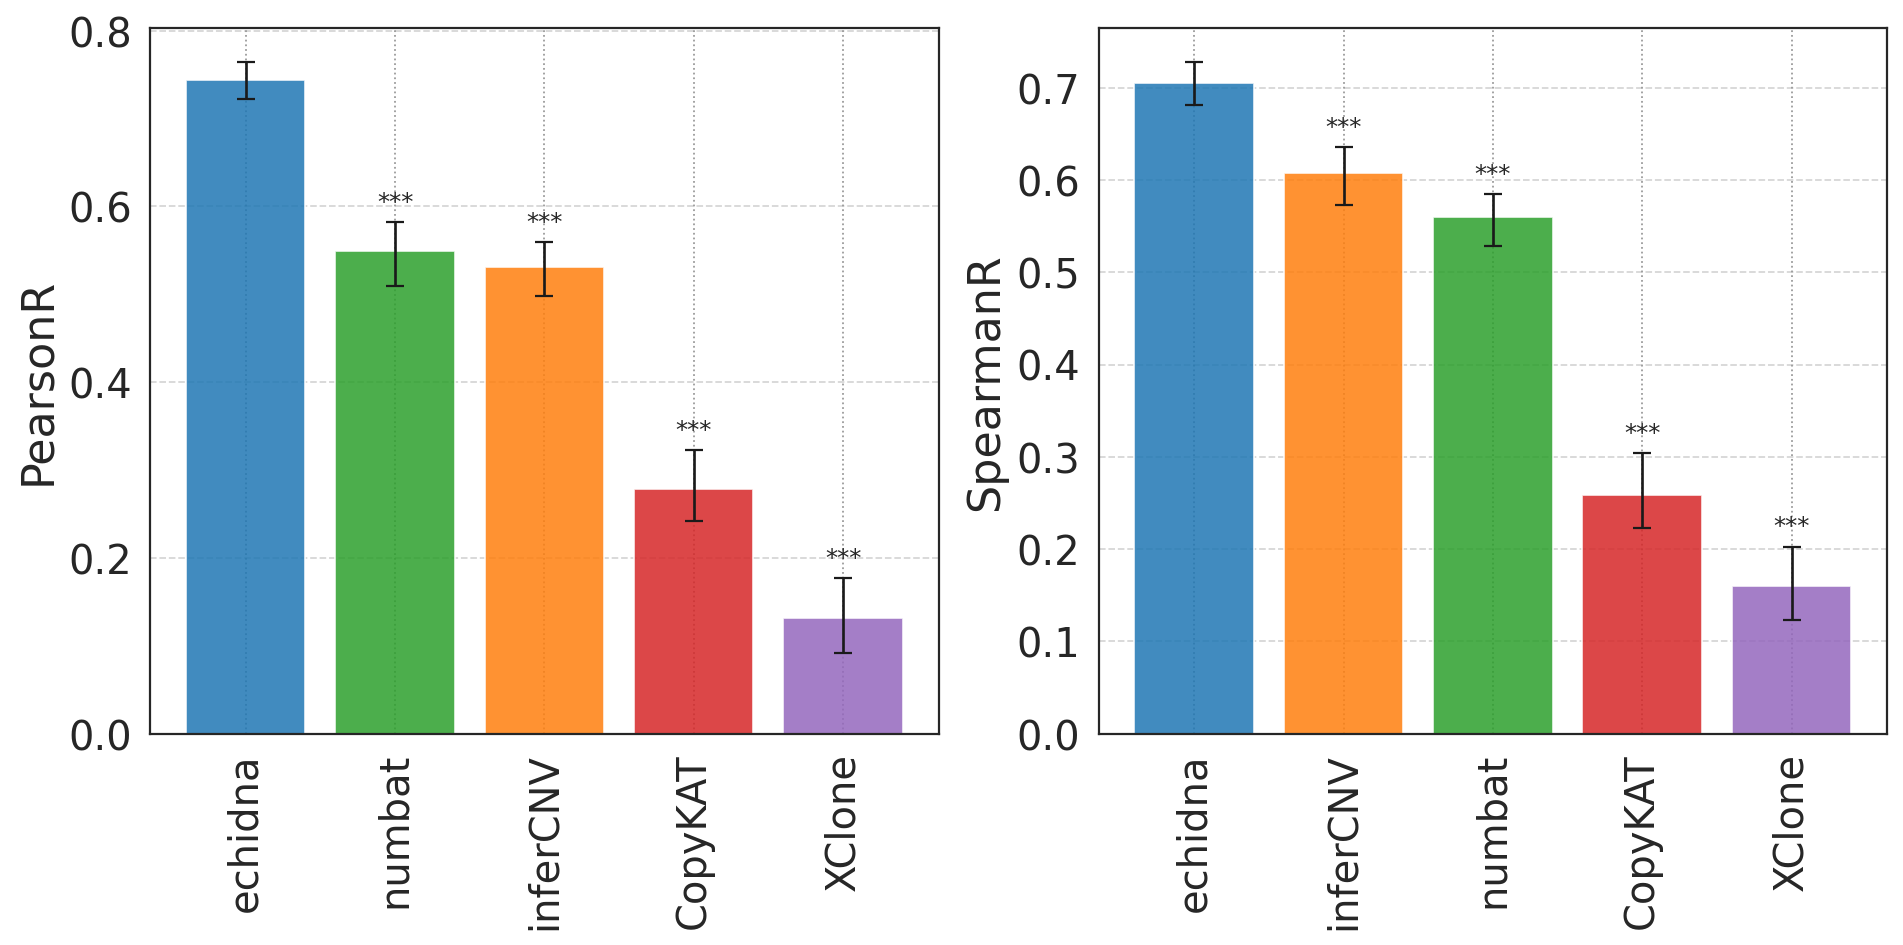

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax = ax.flatten()
plot_metric_bar(ax[0],
                metric="PearsonR",          # column in your DataFrame
                data=metrics,       # DataFrame with '<tool>_clones' rows
                orientation="vertical")
plot_metric_bar(ax[1],
                metric="SpearmanR",          # column in your DataFrame
                data=metrics,       # DataFrame with '<tool>_clones' rows
                orientation="vertical")
plt.tight_layout()
plt.savefig("tumor2_cna_benchmarking.svg", format="svg", bbox_inches='tight', dpi=300)


# CNV state prediction

In [72]:
tumor2 = sc.read_h5ad("/home/mingxuanzhang/echidna/data/tumor2/Tumor2_X.h5ad")
tumor2.obs['barcode_numbat'] = [i.split("_")[0][:-1] for i in tumor2.obs_names]

In [73]:
wdf_tumor2 = pd.read_csv("/home/mingxuanzhang/echidna/data/tumor2/tumor2_processed_w.csv",
                         names=["index", "gene", "counts"],
                         header=0,).set_index("gene").drop("index", axis=1)
wdf_tumor2.head()

,counts
gene,
MIR1302-2HG,1.06135
FAM138A,1.06135
OR4F5,1.06135
AL627309.1,1.06135
AL627309.3,1.06135


In [74]:
def cleaning_ST(adata, wdf):
  matched_genes = adata.var.index.intersection(wdf.index)
  wdf = wdf.loc[matched_genes]
  adata = adata[:, matched_genes]
  wdf = wdf.loc[~wdf.index.duplicated(keep=False)]
  adata = adata[:, wdf.index]
  adata.obs["timepoint"] = "single_tp"
  return adata, wdf

In [75]:
tumor2, wdf_tumor2 = cleaning_ST(tumor2, wdf_tumor2)

/var/tmp/ipykernel_33683/2319707466.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["timepoint"] = "single_tp"


In [76]:
tumor2

AnnData object with n_obs × n_vars = 2337 × 18675
    obs: 'celltypes', 'celltypes_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden', 'barcode_numbat', 'timepoint'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [77]:
adata = tumor2
num_cells = adata.shape[1]
num_genes = adata.shape[-1]
num_clusters = len(adata.obs['leiden'].unique())
q_corr_init = 0.1
q_shape_rate_scaler = 10.0
eta_mean_init = 2.0
lkj_concentration = 1.0

In [78]:
config = ec.tl.EchidnaConfig(
    num_cells=num_cells,
    num_genes=num_genes,
    timepoint_label = "timepoint", # `assert 'timepoint' in adata.obs.columns`
    counts_layer = "counts", # `assert 'counts' in list(adata.layers.keys())`
    clusters = "leiden", # `assert 'leiden' in adata.obs.columns`
    inverse_gamma = True, # Inverse Gamma can be more stable in low data settings
    eta_mean_init = eta_mean_init, # Our genes average approximately two copies
    q_corr_init=q_corr_init,
    q_shape_rate_scaler=q_shape_rate_scaler,
    lkj_concentration=lkj_concentration,
    patience = -1, # turn off early stopping
    n_steps = 500, # Passes through the dataset
)

In [79]:
ec_model = ec.tl.load_model(tumor2,
                            save_folder="/home/mingxuanzhang/echidna/model_tumor2",
                            model_config=config)
eta_tumor2 = ec_model.eta_posterior

## Ground truth

In [30]:
clusters = list(range(len(tumor2.obs['leiden'].unique())))
clusters

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [31]:
DNA_tumor2 =  pd.read_csv("/home/mingxuanzhang/echidna/data/tumor2/DNA_bin_counts_matrix.txt", sep='\t')
map = pd.read_csv("/home/mingxuanzhang/echidna/data/bin-boundaries and genes.txt",sep='\t')
eta_df_tumor2 = pd.DataFrame(eta_tumor2.cpu().detach().numpy(), columns=tumor2.var_names)
eta_binned, discard_bins = binning_eta(eta_df_tumor2)
_, DNA_cluster = get_binned_DNA_orig(tumor2, DNA_tumor2, map, eta_tumor2)
valid_bins = [bin for bin in list(DNA_cluster.columns) if bin not in discard_bins]
DNA_cluster = DNA_cluster[valid_bins]

In [32]:
DNA_cluster

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,2.587798,2.886495,2.005488,2.383187,2.041201,2.164904,2.214401,2.230466,2.645158,2.202723,...,2.055383,2.040276,2.699714,2.175498,1.914041,2.278934,2.700728,2.127516,1.214204,1.486777
1,2.455456,2.983377,2.001624,2.495571,2.157724,2.105547,2.308037,2.136039,2.349191,2.218938,...,2.126433,2.112650,2.739667,2.099360,2.056834,2.205085,2.920238,2.210749,1.260158,1.588785
2,2.592613,2.679372,2.020204,2.483375,2.103293,2.061808,2.415059,2.262017,2.372682,2.312046,...,2.347760,2.214464,2.854585,2.302923,2.180495,2.249975,2.513198,2.332202,1.329168,1.619016
3,2.488511,2.946498,2.021058,2.456916,2.030953,2.157887,2.317076,2.243370,2.517878,2.335649,...,2.074655,2.039708,2.853072,2.080610,1.992174,2.215392,2.659193,2.134018,1.268604,1.489175
4,1.683464,1.431446,1.613348,2.491993,2.092861,2.069679,2.411744,2.254237,2.377740,2.346368,...,2.276026,2.204184,3.001759,2.272607,2.122295,2.266150,2.590491,2.365384,1.214817,1.590120
5,1.624227,1.494440,1.420588,2.207119,1.976791,1.874944,2.005459,1.293581,1.335141,1.318433,...,2.333771,2.133857,3.075027,2.074349,1.909249,2.087975,2.339959,2.512648,1.186727,1.631151
6,2.339710,2.198493,1.837915,2.378183,2.064699,2.071444,2.293750,2.142072,2.112015,2.127316,...,2.287136,2.237845,3.016453,2.235690,2.108261,2.200324,2.439834,2.305453,1.366798,1.596204
7,2.487174,2.879942,2.170689,2.558009,2.185589,2.014815,2.373179,2.332551,2.411921,2.291988,...,2.154464,2.295844,2.979804,2.127649,1.999201,2.286987,2.898356,2.398089,1.731597,1.855907
8,2.586629,2.871282,2.419873,2.574250,2.224162,2.068847,2.422074,2.376216,2.528954,2.478362,...,2.138312,2.105384,2.914309,2.174701,2.224253,2.378098,2.977745,2.666874,1.751466,2.073667
9,2.413531,2.691155,1.930745,2.459397,2.161623,2.145172,2.305472,2.197487,2.450192,2.364566,...,2.103317,2.050828,2.622898,2.233072,2.039096,2.252687,2.791126,2.117678,1.240366,1.378240


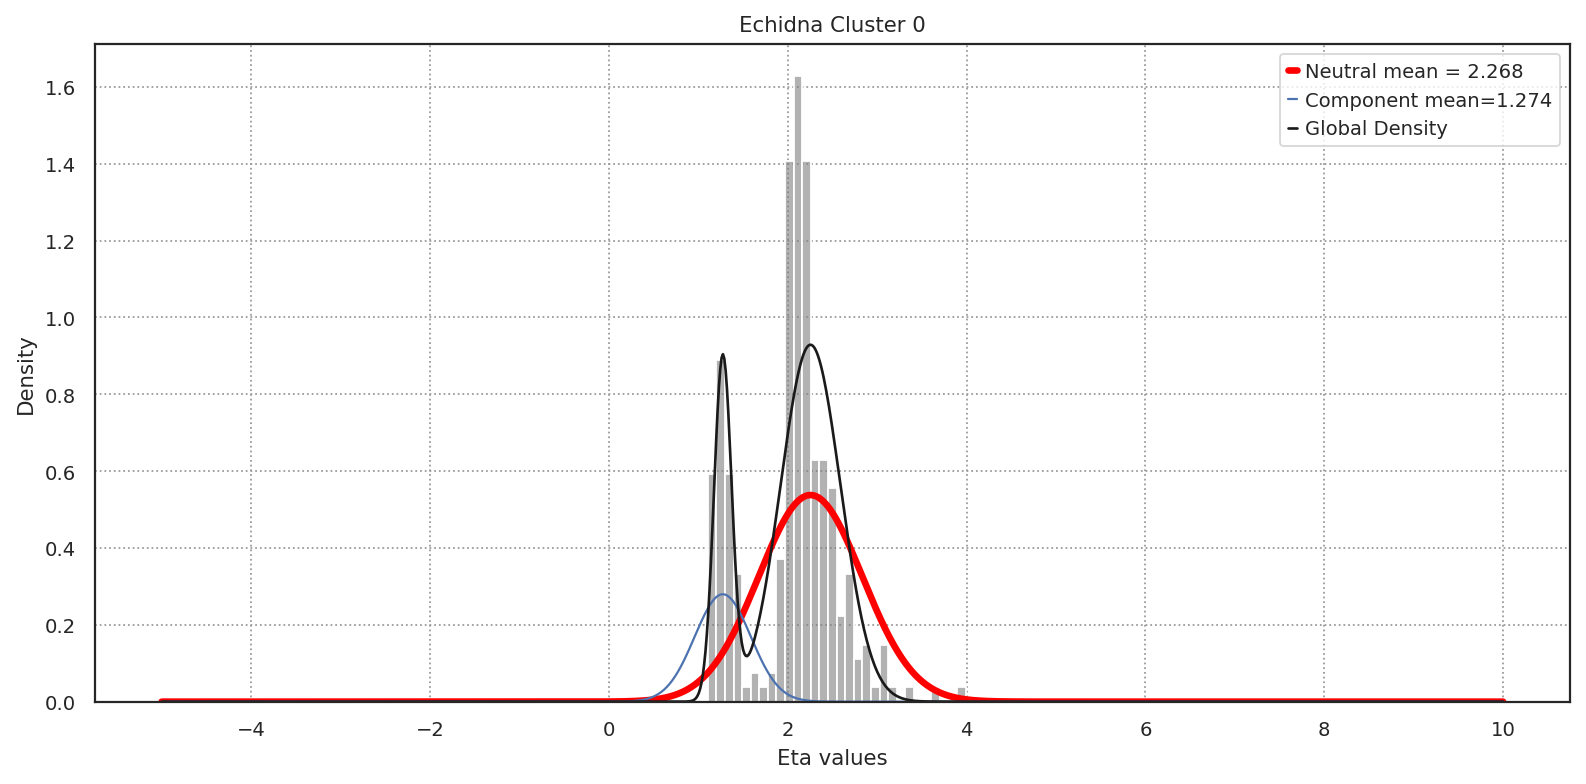

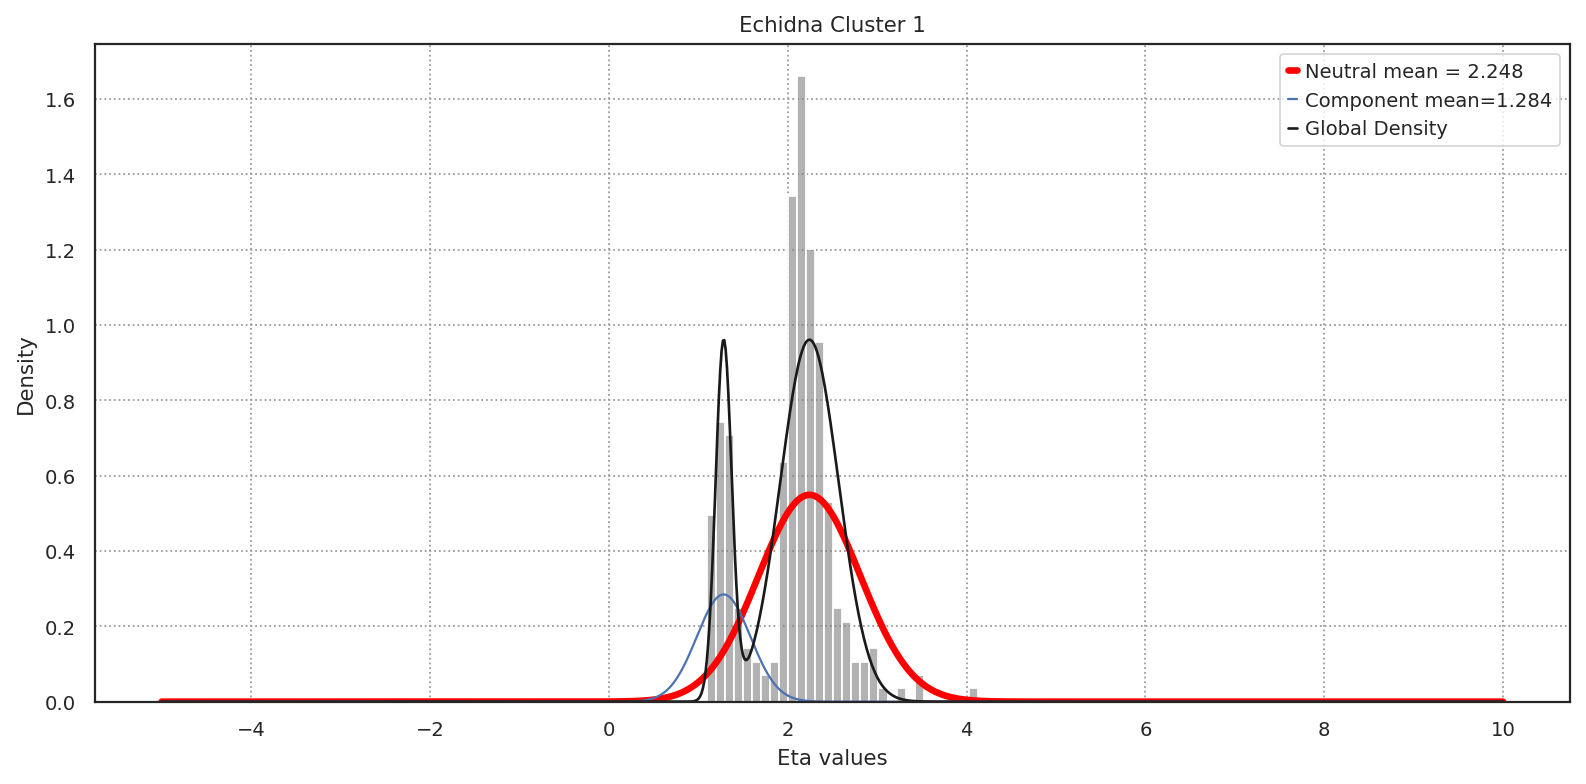

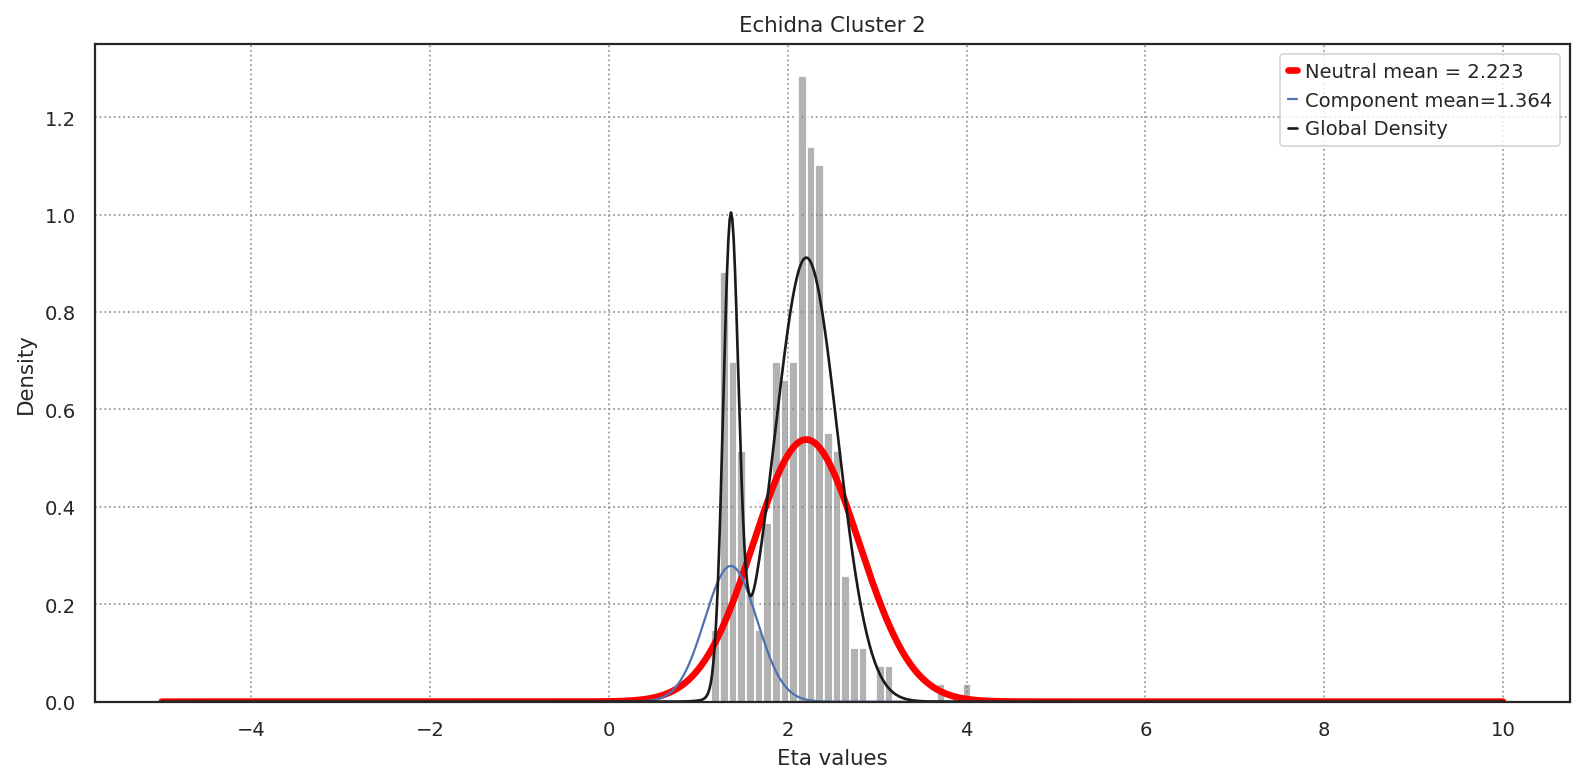

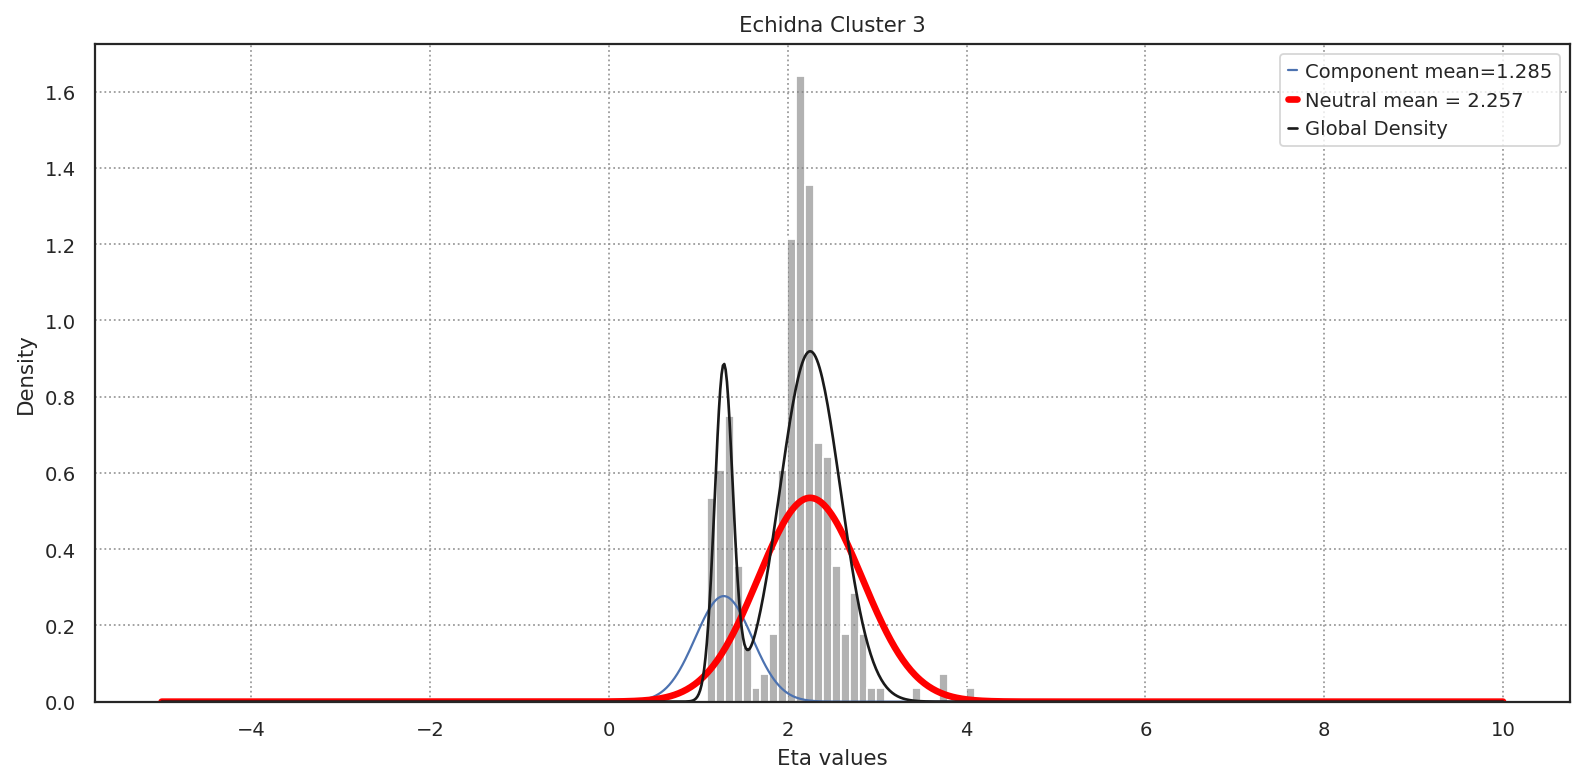

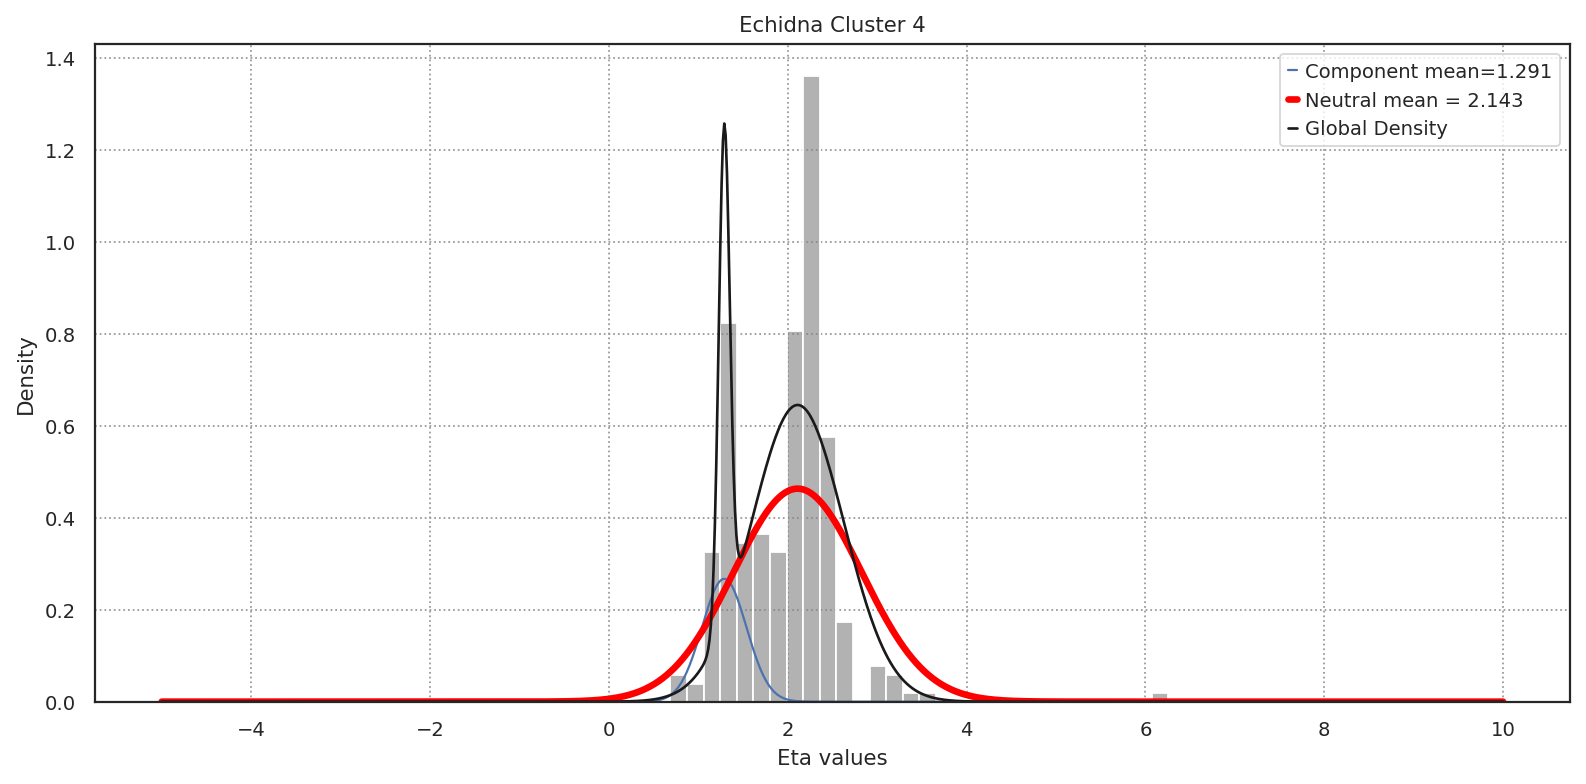

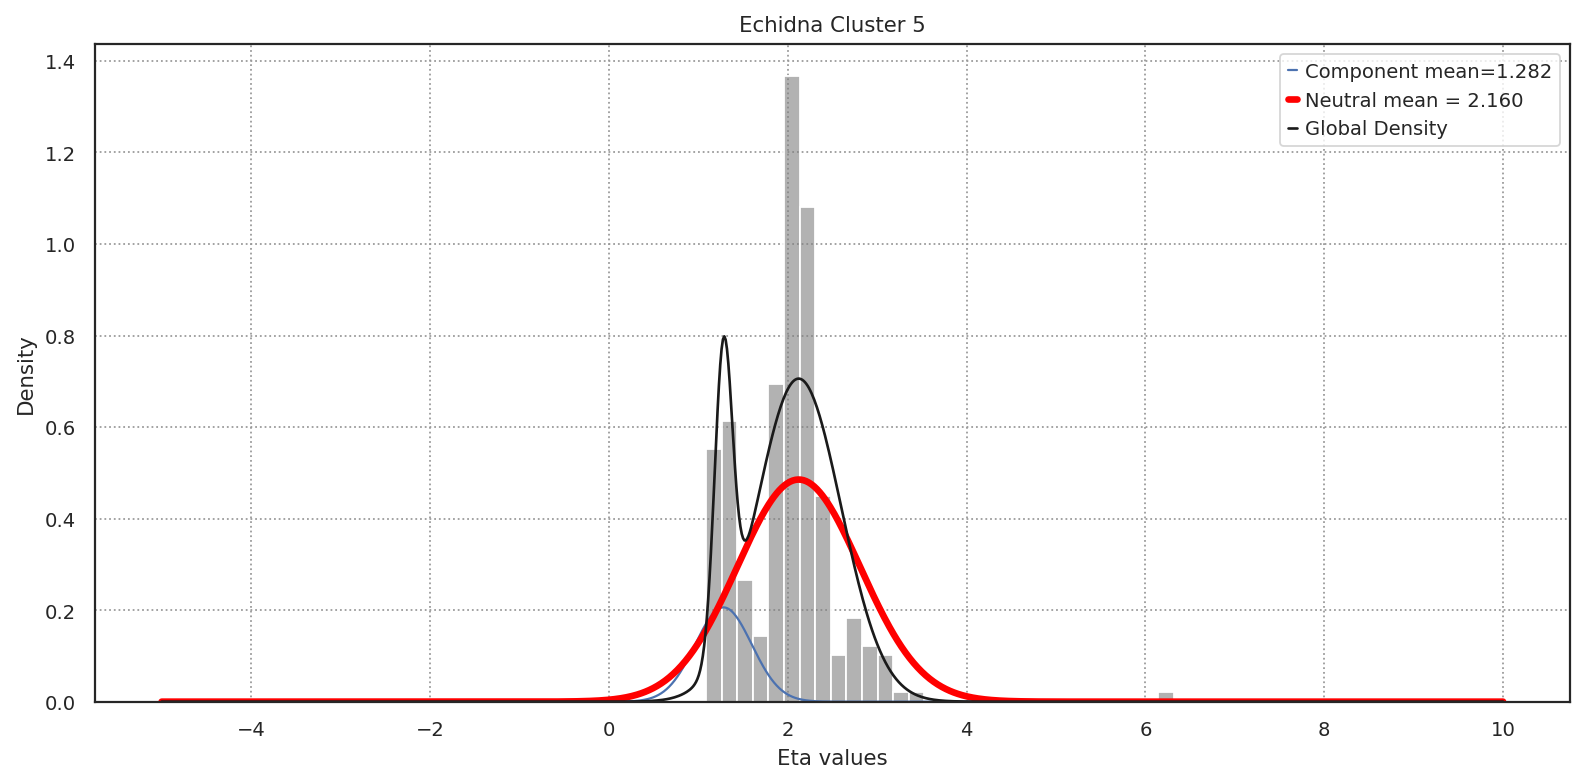

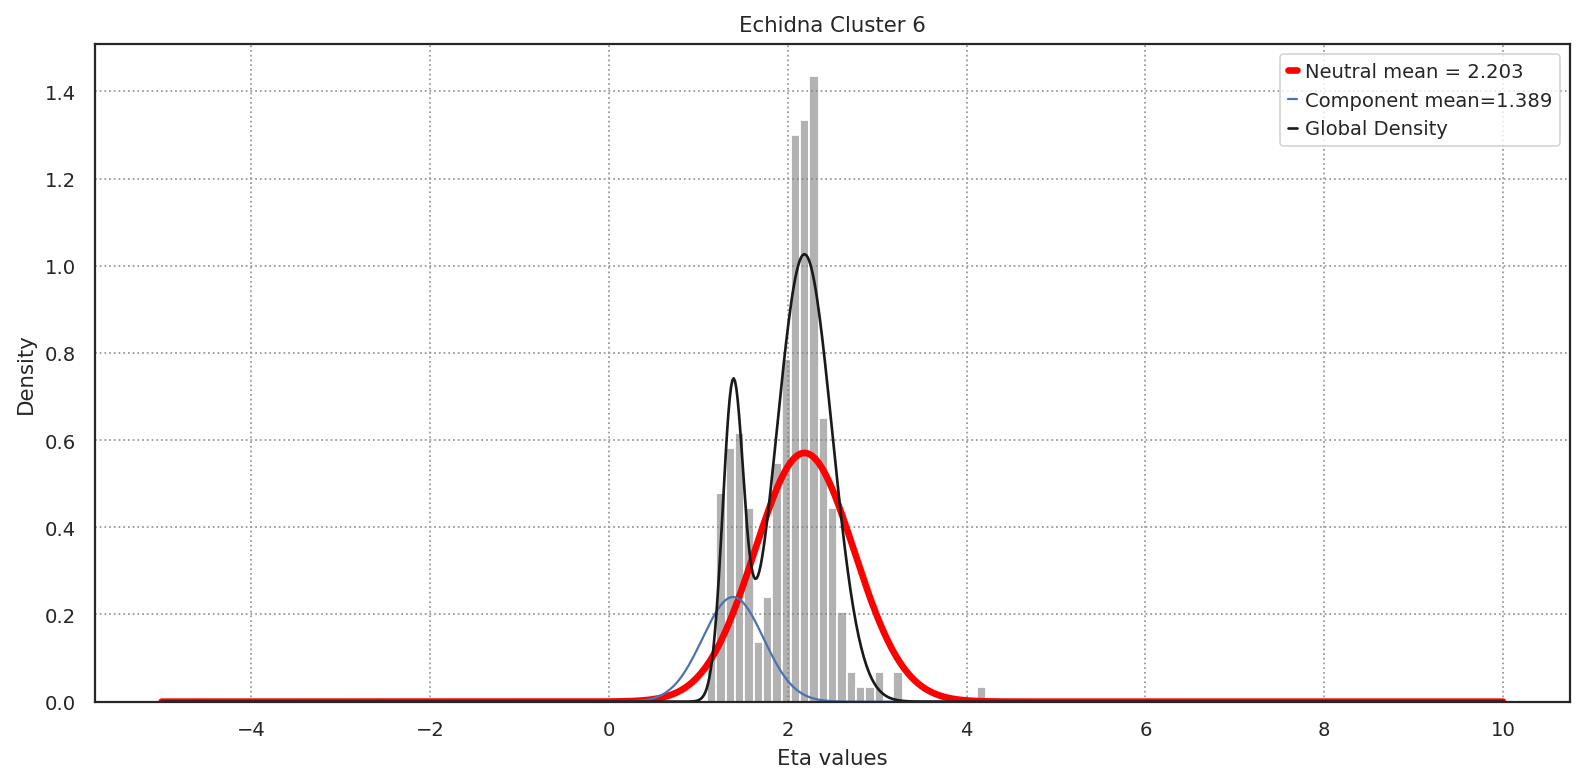

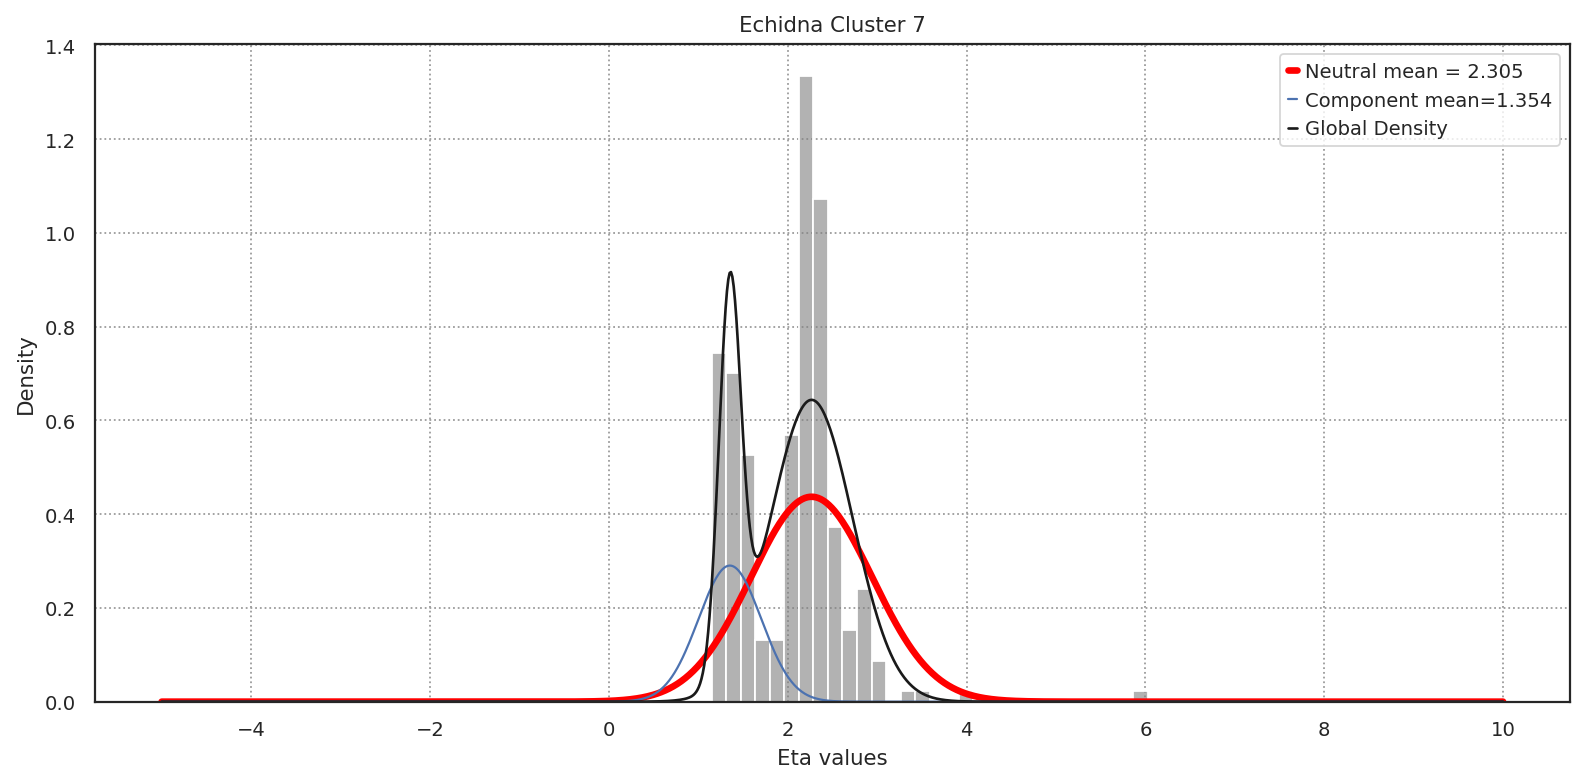

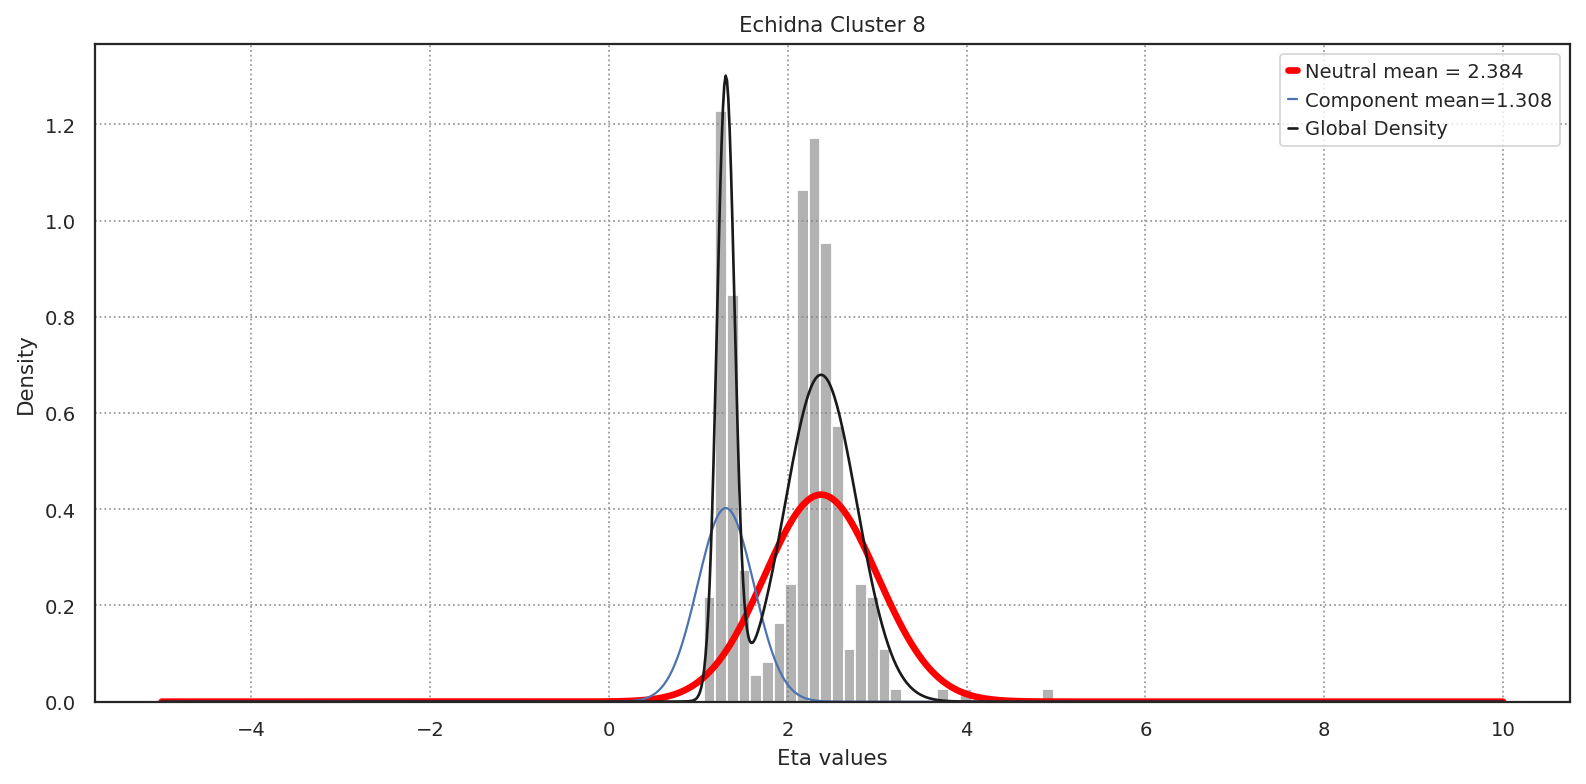

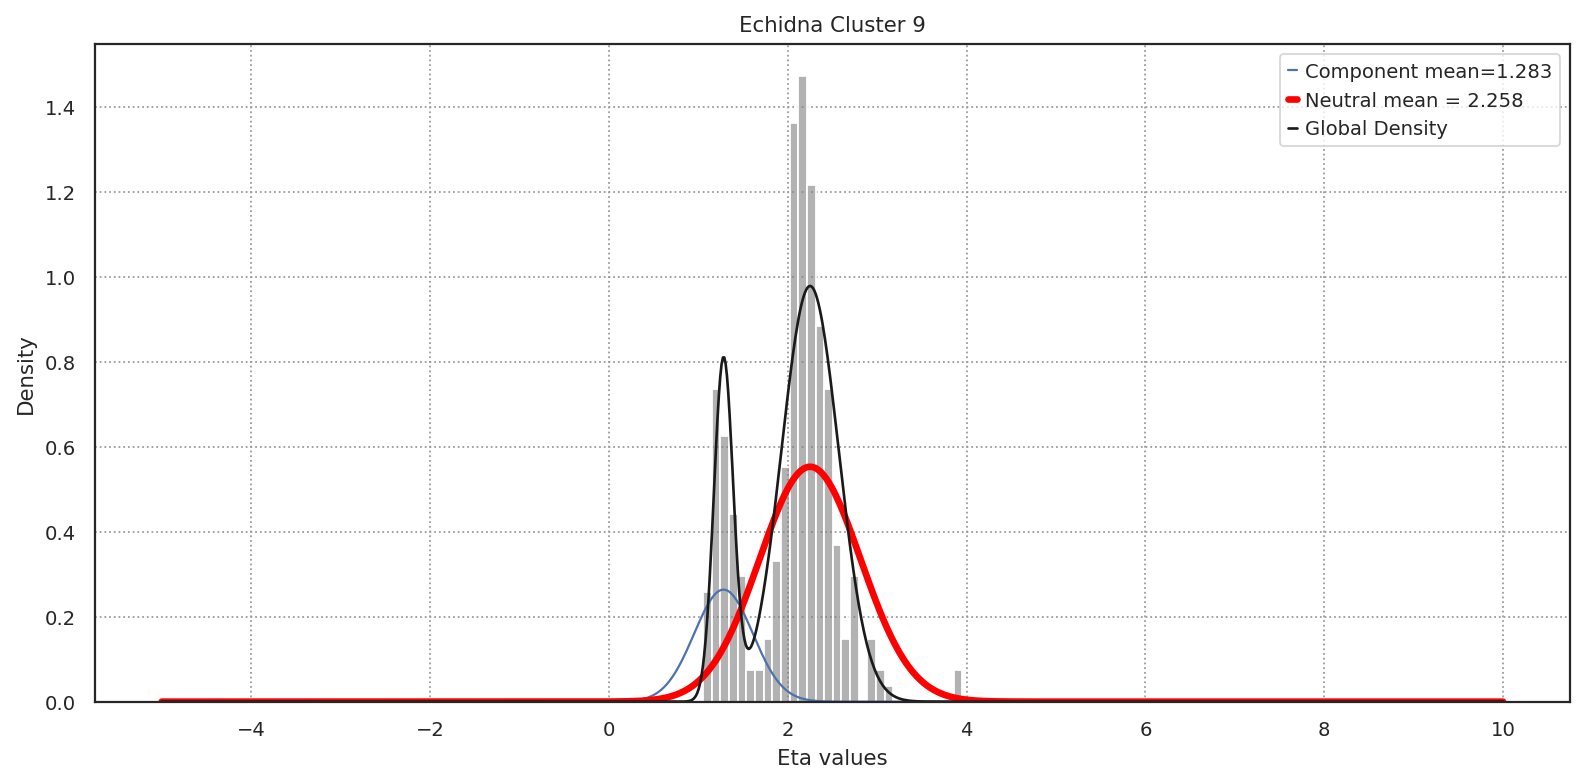

In [33]:
dna_states, X = predict_states_with_binned_cnv(DNA_cluster, clusters, plot_gmm=True, n_comp=2, n_comp_hmm=5)

In [34]:
dna_states

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,del,del
1,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,del,del
2,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,del,del
3,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,amp,neut,neut,neut,amp,neut,del,del
4,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut
5,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut
6,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,amp,neut,neut,neut,neut,neut,del,del
7,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut
8,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut
9,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,del,del


## Echidna result

In [35]:
dna_states_eta, X_eta = predict_states_with_binned_cnv(eta_binned, clusters, plot_gmm=False, n_comp=2, n_iter=500)
dna_states_eta

2025-07-22 02:50:25,444 | WARNING : Model is not converging.  Current: 405.09291552072403 is not greater than 405.0941653961492. Delta is -0.001249875425173741


,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
1,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
2,neut,neut,neut,neut,neut,neut,neut,neut,neut,del,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
3,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
4,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
5,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,amp,del,neut,neut,neut,neut,neut,neut
6,neut,neut,neut,neut,neut,neut,neut,neut,neut,del,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
7,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
8,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut
9,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del


## Numbat result

In [81]:
numbat_bulk = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_tumor2/bulk_clones_final.tsv.gz", sep='\t', compression='gzip')
numbat_bulk = numbat_bulk[numbat_bulk['LLR'] >= 10]
numbat_bulk = numbat_bulk.dropna() #COMMENT THIS OUT FOR TUMOR 5, UNCOMMENT FOR TUMOR 2 
numbat_bulk = numbat_bulk[numbat_bulk['n_cells'] > 50]

/var/tmp/ipykernel_33683/2776643659.py:1: DtypeWarning: Columns (29,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  numbat_bulk = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_tumor2/bulk_clones_final.tsv.gz", sep='\t', compression='gzip')


In [82]:
numbat_bulk

,snp_id,CHROM,POS,cM,REF,ALT,GT,gene,AD,DP,...,cnv_state_post,p_up,haplo_post,haplo_naive,haplo_theta_min,major_count,minor_count,theta_hat_roll,phi_mle_roll,gamma
44202,1_1247494_T_C,1,1247494,1.254771,T,C,1|0,INTS11,0.0,1.0,...,loh,0.029413,minor,minor,minor,1.0,0.0,0.475000,1.035382,20
44213,1_1602536_G_C,1,1602536,1.402684,G,C,1|0,CDK11B,0.0,1.0,...,loh,0.000980,minor,minor,minor,1.0,0.0,0.475207,1.001793,20
44215,1_1635193_T_C,1,1635193,1.402684,T,C,1|0,CDK11A,0.0,1.0,...,loh,0.000980,minor,minor,minor,1.0,0.0,0.475610,0.972847,20
44220,1_1863405_T_C,1,1863405,1.730289,T,C,0|1,CFAP74,0.0,1.0,...,loh,0.493993,major,minor,major,1.0,0.0,0.476000,1.014955,20
44222,1_1990815_C_T,1,1990815,2.276088,C,T,1|0,PRKCZ,1.0,1.0,...,loh,0.949575,major,major,major,1.0,0.0,0.476378,1.015525,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319817,22_51017082_T_A,22,51017082,74.809172,T,A,1|0,CHKB-CPT1B,4.0,4.0,...,del,0.999999,major,major,major,4.0,0.0,0.436709,0.720680,20
319820,22_51062718_C_T,22,51062718,74.840484,C,T,1|0,ARSA,1.0,1.0,...,del,0.999992,major,major,major,1.0,0.0,0.436306,0.745229,20
319825,22_51150428_C_T,22,51150428,75.008492,C,T,1|0,SHANK3,1.0,1.0,...,del,0.999003,major,major,major,1.0,0.0,0.431973,0.752614,20
319827,22_51182485_A_G,22,51182485,75.085202,A,G,1|0,ACR,1.0,1.0,...,del,0.999874,major,major,major,1.0,0.0,0.431034,0.755461,20


In [83]:
numbat_snp_cnv = numbat_bulk[['CHROM', 'POS', 'sample', 'cnv_state_post']]
numbat_snp_cnv['CHROM'] = numbat_snp_cnv['CHROM'].astype(str)
numbat_snp_cnv

/var/tmp/ipykernel_33683/3000576569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numbat_snp_cnv['CHROM'] = numbat_snp_cnv['CHROM'].astype(str)


,CHROM,POS,sample,cnv_state_post
44202,1,1247494,2,loh
44213,1,1602536,2,loh
44215,1,1635193,2,loh
44220,1,1863405,2,loh
44222,1,1990815,2,loh
...,...,...,...,...
319817,22,51017082,5,del
319820,22,51062718,5,del
319825,22,51150428,5,del
319827,22,51182485,5,del


In [84]:
map_loc = pd.read_csv("/home/mingxuanzhang/echidna/data/bin-boundaries and genes.txt",sep='\t')

In [85]:
bins = map[['chr', 'start', 'stop']]
bins['chr'] = bins['chr'].str.replace('chr', '')
bins

/var/tmp/ipykernel_33683/839222554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bins['chr'] = bins['chr'].str.replace('chr', '')


,chr,start,stop
0,1,0,14162233
1,1,14162233,27382184
2,1,27382184,38550236
3,1,38550236,55768724
4,1,55768724,67940820
...,...,...,...
295,X,119113350,126114914
296,X,126114914,134090813
297,X,134090813,141191109
298,X,141191109,146142467


In [86]:

bins['bin_id'] = bins.apply(lambda x: f"{x['chr']}:{x['start']}-{x['stop']}", axis=1)
bins

/var/tmp/ipykernel_33683/1114301274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bins['bin_id'] = bins.apply(lambda x: f"{x['chr']}:{x['start']}-{x['stop']}", axis=1)


,chr,start,stop,bin_id
0,1,0,14162233,1:0-14162233
1,1,14162233,27382184,1:14162233-27382184
2,1,27382184,38550236,1:27382184-38550236
3,1,38550236,55768724,1:38550236-55768724
4,1,55768724,67940820,1:55768724-67940820
...,...,...,...,...
295,X,119113350,126114914,X:119113350-126114914
296,X,126114914,134090813,X:126114914-134090813
297,X,134090813,141191109,X:134090813-141191109
298,X,141191109,146142467,X:141191109-146142467


In [87]:
merged = pd.merge(numbat_snp_cnv, bins, left_on='CHROM', right_on='chr', how='inner')
merged

,CHROM,POS,sample,cnv_state_post,chr,start,stop,bin_id
0,1,1247494,2,loh,1,0,14162233,1:0-14162233
1,1,1247494,2,loh,1,14162233,27382184,1:14162233-27382184
2,1,1247494,2,loh,1,27382184,38550236,1:27382184-38550236
3,1,1247494,2,loh,1,38550236,55768724,1:38550236-55768724
4,1,1247494,2,loh,1,55768724,67940820,1:55768724-67940820
...,...,...,...,...,...,...,...,...
180355,22,51182485,5,del,22,25951792,37344882,22:25951792-37344882
180356,22,51182485,5,del,22,37344882,51304566,22:37344882-51304566
180357,22,51206533,5,del,22,0,25951792,22:0-25951792
180358,22,51206533,5,del,22,25951792,37344882,22:25951792-37344882


In [88]:
merged = merged[(merged['POS'] >= merged['start']) & (merged['POS'] <= merged['stop'])]
merged

,CHROM,POS,sample,cnv_state_post,chr,start,stop,bin_id
0,1,1247494,2,loh,1,0,14162233,1:0-14162233
21,1,1602536,2,loh,1,0,14162233,1:0-14162233
42,1,1635193,2,loh,1,0,14162233,1:0-14162233
63,1,1863405,2,loh,1,0,14162233,1:0-14162233
84,1,1990815,2,loh,1,0,14162233,1:0-14162233
...,...,...,...,...,...,...,...,...
180347,22,51017082,5,del,22,37344882,51304566,22:37344882-51304566
180350,22,51062718,5,del,22,37344882,51304566,22:37344882-51304566
180353,22,51150428,5,del,22,37344882,51304566,22:37344882-51304566
180356,22,51182485,5,del,22,37344882,51304566,22:37344882-51304566


In [89]:
def mode_func(x):
    return x.value_counts().idxmax()

grouped = merged.groupby(['sample', 'bin_id'], as_index=False)['cnv_state_post'].apply(mode_func)
clone_by_bin_cnv_states = grouped.pivot(index='sample', columns='bin_id', values='cnv_state_post')
clone_by_bin_cnv_states

bin_id,10:0-8887914,10:109080866-115498362,10:115498362-125734756,10:125734756-135534747,10:22351496-33718741,10:33718741-42387024,10:42387024-48125910,10:48125910-59728209,10:59728209-67648363,10:67648363-83248665,...,9:114270481-122850249,9:122850249-141213431,9:18324230-25531316,9:25531316-32373343,9:32373343-42504875,9:42504875-71297094,9:71297094-81384553,9:81384553-87222108,9:87222108-96109552,9:96109552-106724384
sample,,,,,,,,,,,,,,,,,,,,,
2,loh,loh,loh,loh,loh,loh,loh,loh,loh,loh,...,del,del,del,del,del,NaN,del,NaN,del,del
3,loh,loh,loh,loh,loh,loh,loh,loh,loh,loh,...,del,del,loh,loh,loh,NaN,del,del,del,del
4,amp,amp,amp,amp,amp,amp,amp,amp,amp,amp,...,loh,loh,amp,amp,amp,loh,loh,loh,loh,loh
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,del,del,del,del,del,del,del,del,del,del


In [90]:
clone_by_bin_cnv_states.fillna('neut', inplace=True)
clone_by_bin_cnv_states

bin_id,10:0-8887914,10:109080866-115498362,10:115498362-125734756,10:125734756-135534747,10:22351496-33718741,10:33718741-42387024,10:42387024-48125910,10:48125910-59728209,10:59728209-67648363,10:67648363-83248665,...,9:114270481-122850249,9:122850249-141213431,9:18324230-25531316,9:25531316-32373343,9:32373343-42504875,9:42504875-71297094,9:71297094-81384553,9:81384553-87222108,9:87222108-96109552,9:96109552-106724384
sample,,,,,,,,,,,,,,,,,,,,,
2,loh,loh,loh,loh,loh,loh,loh,loh,loh,loh,...,del,del,del,del,del,neut,del,neut,del,del
3,loh,loh,loh,loh,loh,loh,loh,loh,loh,loh,...,del,del,loh,loh,loh,neut,del,del,del,del
4,amp,amp,amp,amp,amp,amp,amp,amp,amp,amp,...,loh,loh,amp,amp,amp,loh,loh,loh,loh,loh
5,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,del,del,del,del,del,del,del,del,del,del


In [91]:
clone_by_bin_cnv_states = clone_by_bin_cnv_states.replace('loh', 'del', regex=True)
clone_by_bin_cnv_states

bin_id,10:0-8887914,10:109080866-115498362,10:115498362-125734756,10:125734756-135534747,10:22351496-33718741,10:33718741-42387024,10:42387024-48125910,10:48125910-59728209,10:59728209-67648363,10:67648363-83248665,...,9:114270481-122850249,9:122850249-141213431,9:18324230-25531316,9:25531316-32373343,9:32373343-42504875,9:42504875-71297094,9:71297094-81384553,9:81384553-87222108,9:87222108-96109552,9:96109552-106724384
sample,,,,,,,,,,,,,,,,,,,,,
2,del,del,del,del,del,del,del,del,del,del,...,del,del,del,del,del,neut,del,neut,del,del
3,del,del,del,del,del,del,del,del,del,del,...,del,del,del,del,del,neut,del,del,del,del
4,amp,amp,amp,amp,amp,amp,amp,amp,amp,amp,...,del,del,amp,amp,amp,del,del,del,del,del
5,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,del,del,del,del,del,del,del,del,del,del


In [92]:
DNA_cluster_numbat = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_numbat_tumor2.csv", index_col=0)

In [93]:
clone_by_bin_cnv_states.fillna('neut', inplace=True)
clone_by_bin_cnv_states = clone_by_bin_cnv_states.replace('loh', 'del', regex=True)
valid_bins_numbat = [int(i) for i in list(DNA_cluster_numbat.columns)]

In [94]:
valid_bin_id_numbat = [bins.loc[i]['bin_id'] for i in valid_bins_numbat]
clone_by_bin_cnv_states = clone_by_bin_cnv_states[valid_bin_id_numbat]

In [95]:
clone_by_bin_cnv_states.loc[1] = ['neut'] * len(clone_by_bin_cnv_states.columns)
clone_by_bin_cnv_states.index.names = ['clones']

In [96]:
clone_by_bin_cnv_states

bin_id,1:0-14162233,1:14162233-27382184,1:27382184-38550236,1:38550236-55768724,1:55768724-67940820,1:67940820-79160729,1:79160729-86982135,1:86982135-96283209,1:96283209-104492031,1:104492031-111805851,...,20:0-7804049,20:7804049-17782370,20:17782370-24263259,20:24263259-38441132,20:38441132-47111949,20:47111949-54361321,20:54361321-63025520,22:0-25951792,22:25951792-37344882,22:37344882-51304566
clones,,,,,,,,,,,,,,,,,,,,,
2,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
3,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,amp,amp,amp,amp,amp,amp,amp,del,del,del
4,amp,amp,amp,amp,amp,amp,amp,amp,amp,amp,...,amp,amp,amp,amp,amp,amp,amp,del,del,del
5,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
1,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut


In [97]:
tumor2.obs['leiden']

AAACATAAAGATGTATG1_2    4
AAACATAGAACCGGTTG1_2    3
AAACATCTTGGCTCAAG1_2    3
AAACATGTTACTCGAAT1_2    4
AAACATGTTCCCCGTTC1_2    1
                       ..
TTTTATTAATTTCGTGA2_2    7
TTTTATTAATTTGATGT2_2    1
TTTTATTAGCCTGGATT2_2    8
TTTTATTCTTCAAGATC2_2    1
TTTTATTTGACTATTAA2_2    7
Name: leiden, Length: 2337, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [98]:
numbat_clones = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/numbat_tumor2/clone_post_2.tsv", sep='\t')
numbat_clones.index = numbat_clones['cell']
tumor2.obs_names = tumor2.obs['barcode_numbat']
overlapping_barcodes = set(list(tumor2.obs_names)).intersection(set(list(numbat_clones.index)))
tumor2 = tumor2[tumor2.obs_names.isin(overlapping_barcodes)]
numbat_clones = numbat_clones.loc[list(overlapping_barcodes)]
numbat_clones = numbat_clones.reindex(tumor2.obs_names)
tumor2.obs['numbat_clones'] = numbat_clones['clone_opt'].astype(str)
nb_clones = numbat_clones[['cell', 'clone_opt']]
nb_clones['cluster'] = tumor2.obs['leiden']
nb_clones_grouped = nb_clones.groupby('cluster')['clone_opt'].apply(lambda x: x.value_counts().idxmax())
#nb_clones

/var/tmp/ipykernel_33683/355301700.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tumor2.obs['numbat_clones'] = numbat_clones['clone_opt'].astype(str)
/var/tmp/ipykernel_33683/355301700.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_clones['cluster'] = tumor2.obs['leiden']
/var/tmp/ipykernel_33683/355301700.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  nb_clones_grouped = nb_clones.groupby('cluster')['clone_opt'].apply(lambda x: x.value_counts().idxmax())


In [99]:
cluster_by_bin_cnv_states = clone_by_bin_cnv_states.reindex(index=nb_clones_grouped.values)
cluster_by_bin_cnv_states.index = nb_clones_grouped.index

In [100]:
pred_states_numbat = cluster_by_bin_cnv_states
pred_states_numbat

bin_id,1:0-14162233,1:14162233-27382184,1:27382184-38550236,1:38550236-55768724,1:55768724-67940820,1:67940820-79160729,1:79160729-86982135,1:86982135-96283209,1:96283209-104492031,1:104492031-111805851,...,20:0-7804049,20:7804049-17782370,20:17782370-24263259,20:24263259-38441132,20:38441132-47111949,20:47111949-54361321,20:54361321-63025520,22:0-25951792,22:25951792-37344882,22:37344882-51304566
cluster,,,,,,,,,,,,,,,,,,,,,
0,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
1,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
2,amp,amp,amp,amp,amp,amp,amp,amp,amp,amp,...,amp,amp,amp,amp,amp,amp,amp,del,del,del
3,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
4,amp,amp,amp,amp,amp,amp,amp,amp,amp,amp,...,amp,amp,amp,amp,amp,amp,amp,del,del,del
5,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,amp,amp,amp,amp,amp,amp,amp,del,del,del
6,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
7,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
8,del,del,del,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,del,del,del


## inferCNV result

In [101]:
DNA_cluster_infercnv = pd.read_csv("/home/mingxuanzhang/echidna/benchmarking_data/DNA_cluster_infercnv_tumor2.csv", index_col=0)
valid_bins_infercnv = [int(i) for i in list(DNA_cluster_infercnv.columns)]

In [102]:
def assign_cnv_states_infercnv(data, threshold=1.96):
    # Compute mean and std for each row
    row_means = data.mean(axis=1)
    row_stds = data.std(axis=1)
    result = np.empty_like(data, dtype=object)
    # Precompute threshold bounds for each element
    lower_thresh = row_means - threshold * row_stds
    upper_thresh = row_means + threshold * row_stds

    # Assign states
    # Criteria:
    # amp: value > mean + threshold * std
    # del: value < mean - threshold * std
    # neut: otherwise
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            if val > upper_thresh[i]:
                result[i, j] = "amp"
            elif val < lower_thresh[i]:
                result[i, j] = "del"
            else:
                # Default case is "neut"
                result[i, j] = "neut"

    return pd.DataFrame(result)

## CopyKAT result

In [103]:
dna_copykat.shape

(10, 257)

In [104]:
dna_states_copykat = assign_cnv_states_infercnv(dna_copykat, threshold=1.0)
dna_states_copykat

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,amp,amp,neut,neut,neut,neut,neut,neut,amp,neut,...,neut,neut,neut,amp,neut,neut,amp,neut,del,del
1,neut,amp,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,amp,neut,neut,amp,neut,del,neut
2,amp,amp,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,amp,neut,neut,neut,neut,del,neut
3,neut,amp,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,amp,neut,neut,amp,neut,del,del
4,neut,del,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,amp,neut,neut,amp,neut,del,neut
5,neut,neut,del,neut,neut,neut,neut,del,del,del,...,neut,neut,neut,amp,neut,neut,neut,neut,del,neut
6,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,amp,neut,neut,neut,neut,del,del
7,neut,amp,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,amp,neut,neut,amp,neut,neut,neut
8,neut,amp,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,amp,neut,neut,amp,amp,neut,neut
9,neut,amp,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,amp,neut,neut,amp,neut,del,del


## Xclone result

0 = del, 1 = neut, 2 = amp

In [105]:
tumor2 = sc.read_h5ad("/home/mingxuanzhang/echidna/data/tumor2/Tumor2_X.h5ad")
tumor2.obs['barcode_xclone'] = [i.split("_")[0][:-1] for i in tumor2.obs_names]
tumor2.obs['barcode_xclone'] 

AAACATAAAGATGTATG1_2    AAACATAAAGATGTATG
AAACATAGAACCGGTTG1_2    AAACATAGAACCGGTTG
AAACATCTTGGCTCAAG1_2    AAACATCTTGGCTCAAG
AAACATGTTACTCGAAT1_2    AAACATGTTACTCGAAT
AAACATGTTCCCCGTTC1_2    AAACATGTTCCCCGTTC
                              ...        
TTTTATTAATTTCGTGA2_2    TTTTATTAATTTCGTGA
TTTTATTAATTTGATGT2_2    TTTTATTAATTTGATGT
TTTTATTAGCCTGGATT2_2    TTTTATTAGCCTGGATT
TTTTATTCTTCAAGATC2_2    TTTTATTCTTCAAGATC
TTTTATTTGACTATTAA2_2    TTTTATTTGACTATTAA
Name: barcode_xclone, Length: 2337, dtype: object

In [107]:
xclone = sc.read_h5ad("/home/mingxuanzhang/echidna/benchmarking_data/xlcone_tumor2/data/xclone_tumor2_outputs_combine2_data_combined_final.h5ad")
xclone

AnnData object with n_obs × n_vars = 2806 × 3487
    obs: 'matched_name', 'Type', 'cell_type', 'counts_ratio'
    var: 'GeneName', 'GeneID', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band', 'ref_avg', 'dispersion', 'gene_dispersion_bse', 'dispersion_capped', 'gene_index'
    uns: 'CNV_ratio', 'Logliklihood', 'chr_dict', 'data_mode', 'data_notes', 'dispersion_base_celltype', 'fit_dispersion_removed_genes', 'genome_mode', 'group_genes', 'guide_CNV_chrs_use_anno_key', 'guide_CNV_chrs_use_layers', 'log', 'neighbors', 'pca', 'rank_marker_genes', 'ref_log_expression_brk'
    obsm: 'WGD_prop', 'X_pca'
    varm: 'PCs'
    layers: 'BAF_extend_post_prob', 'RDR_smooth', 'WGD_bool', 'combine_base_prob', 'corrected_prob', 'plot_prob_merge1', 'plot_prob_merge2', 'plot_prob_merge3', 'plot_prob_merge4', 'posterior_mtx', 'posterior_mtx_log', 'prob1_merge', 'raw_expr', 'rdr_posterior_mtx_denoised'
    obsp: 'connectivities', 'distances'

In [108]:
xclone.obs['matched_name']

AAACATAAAGATGTATG    AAACATAAAGATGTATG
AAACATAAATCCGTTGA    AAACATAAATCCGTTGA
AAACATAAATCCTGTAA    AAACATAAATCCTGTAA
AAACATAACAAGGGATT    AAACATAACAAGGGATT
AAACATAACCTGCATGG    AAACATAACCTGCATGG
                           ...        
TTTTATTCTTCAAGATC    TTTTATTCTTCAAGATC
TTTTATTGAGGTAGATC    TTTTATTGAGGTAGATC
TTTTATTGGCGAAGATC    TTTTATTGGCGAAGATC
TTTTATTTCGGCATACG    TTTTATTTCGGCATACG
TTTTATTTGACTTTATT    TTTTATTTGACTTTATT
Name: matched_name, Length: 2806, dtype: object

In [109]:
xclone.obs_names

Index(['AAACATAAAGATGTATG', 'AAACATAAATCCGTTGA', 'AAACATAAATCCTGTAA',
       'AAACATAACAAGGGATT', 'AAACATAACCTGCATGG', 'AAACATAACTTTCAATA',
       'AAACATACTGGCGTAAT', 'AAACATAGAACCGGTTG', 'AAACATAGAGCGGCAGT',
       'AAACATAGTTTGGATGT',
       ...
       'TTTTATGTTTTACGAAT', 'TTTTATTAAGCTGGTTG', 'TTTTATTAATTTGATGT',
       'TTTTATTAGCCTGGATT', 'TTTTATTATGGCACAAT', 'TTTTATTCTTCAAGATC',
       'TTTTATTGAGGTAGATC', 'TTTTATTGGCGAAGATC', 'TTTTATTTCGGCATACG',
       'TTTTATTTGACTTTATT'],
      dtype='object', length=2806)

In [110]:
xclone_cells = list(xclone.obs['matched_name'])
tumor2_cells = list(tumor2.obs['barcode_xclone'])
overlapping_cells = list(set(xclone_cells).intersection(set(tumor2_cells)))
xclone = xclone[overlapping_cells, :]
xclone

View of AnnData object with n_obs × n_vars = 1844 × 3487
    obs: 'matched_name', 'Type', 'cell_type', 'counts_ratio'
    var: 'GeneName', 'GeneID', 'chr', 'start', 'stop', 'arm', 'chr_arm', 'band', 'ref_avg', 'dispersion', 'gene_dispersion_bse', 'dispersion_capped', 'gene_index'
    uns: 'CNV_ratio', 'Logliklihood', 'chr_dict', 'data_mode', 'data_notes', 'dispersion_base_celltype', 'fit_dispersion_removed_genes', 'genome_mode', 'group_genes', 'guide_CNV_chrs_use_anno_key', 'guide_CNV_chrs_use_layers', 'log', 'neighbors', 'pca', 'rank_marker_genes', 'ref_log_expression_brk'
    obsm: 'WGD_prop', 'X_pca'
    varm: 'PCs'
    layers: 'BAF_extend_post_prob', 'RDR_smooth', 'WGD_bool', 'combine_base_prob', 'corrected_prob', 'plot_prob_merge1', 'plot_prob_merge2', 'plot_prob_merge3', 'plot_prob_merge4', 'posterior_mtx', 'posterior_mtx_log', 'prob1_merge', 'raw_expr', 'rdr_posterior_mtx_denoised'
    obsp: 'connectivities', 'distances'

In [111]:
tumor2.obs_names = tumor2.obs['barcode_xclone']
tumor2_reordered = tumor2[overlapping_cells, :]
tumor2_reordered

View of AnnData object with n_obs × n_vars = 1844 × 29639
    obs: 'celltypes', 'celltypes_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_original_total_counts', 'leiden', 'barcode_xclone'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [112]:
prob = np.array(xclone.layers['posterior_mtx'])
prob.shape

(1844, 3487, 3)

In [113]:
cluster_labels = list(tumor2_reordered.obs['leiden'].astype(int))

In [114]:
import numpy as np
from typing import Sequence, Tuple

def average_cnv_by_cluster_fixed_ids(
        prob_3d: np.ndarray,
        cluster_labels: Sequence[int],
) -> Tuple[np.ndarray, np.ndarray]:

    # ---- allocate -----------------------------------------------------------
    n_clusters = cluster_labels.max() + 1        # preserves numeric IDs
    n_genes    = prob_3d.shape[1]

    sums   = np.zeros((n_clusters, n_genes, 3), dtype=prob_3d.dtype)
    counts = np.zeros(n_clusters, dtype=int)

    # ---- accumulate sums & counts in one pass ------------------------------
    np.add.at(sums,   cluster_labels, prob_3d)   # per-cluster sum
    np.add.at(counts, cluster_labels, 1)         # per-cluster cell count

    # ---- convert to means; mark empty clusters with NaN --------------------
    with np.errstate(divide='ignore', invalid='ignore'):
        means = sums / counts[:, None, None]
    means[counts == 0] = np.nan                  # clusters with no cells

    return means, counts

In [115]:
xclone_cluster_level_prob, _ = average_cnv_by_cluster_fixed_ids(
    prob, np.array(cluster_labels)
)

In [116]:
xclone_cluster_level_prob.shape

(10, 3487, 3)

In [117]:
map = map.loc[valid_bins, :]
map

,chr,start,stop,abspos,length,gc,n_good,genes
0,chr1,0,14162233,7081116,14162233,0.485181,213318,"MIR7846,ERRFI1,PRAMEF10,PLOD1,UBE2J2,C1orf127,..."
1,chr1,14162233,27382184,20772208,13219951,0.473007,213318,"DHDDS-AS1,MIR6084,CD52,IFFO2,PINK1-AS,CTRC,LYP..."
2,chr1,27382184,38550236,32966210,11168052,0.470651,213319,"SYTL1,ADPRS,MIR5585,A3GALT2,EVA1B,MIR5581,GJB4..."
3,chr1,38550236,55768724,47159480,17218488,0.451368,213319,"MIR30E,HECTD3,LINC01398,PCSK9,RNF11,PARS2,MIR5..."
4,chr1,55768724,67940820,61854772,12172096,0.408516,213318,"CYP2J2,TM2D1,PGM1,SLC35D1,DAB1-AS1,OMA1,MIR606..."
...,...,...,...,...,...,...,...,...
276,chr21,28403521,35651042,2813626106,7247521,0.393563,178777,"EVA1C,IFNAR2,IFNAR1,SON,CLDN17,ITSN1,LINC00159..."
277,chr21,35651042,48129895,2823489293,12478853,0.464840,178774,"KCNE2,KCNE1,FAM3B,FTCD,MIR802,TRAPPC10,LOC1027..."
278,chr22,0,25951792,2842704616,25951792,0.464105,164363,"MIR6817,POM121L8P,MIR3198-1,DRICH1,CRKL,LINC00..."
279,chr22,25951792,37344882,2861377057,11393090,0.456255,164360,"LIF,LINC01399,TIMP3,CASTOR1,HPS4,KIAA1656,IFT2..."


In [118]:
def bin_cnv_majority(
        prob_3d:      np.ndarray,
        gene_names:   List[str],
        gene_map:     pd.DataFrame,
        *,
        tie_break: str = "prob"            # 'prob', 'first', 'random'
) -> Tuple[pd.DataFrame, List]:

    # --- lookup helpers ------------------------------------------------------
    state_to_str = np.array(["del", "neut", "amp"])      # 0→del, 1→neut, 2→amp
    gene_to_idx  = {g: i for i, g in enumerate(gene_names)}

    binned_cols   = []           # list of (n_cells, 1) arrays
    valid_bins    = []           # names for kept bins
    discarded_bins = []
    rng           = np.random.default_rng()

    # --- iterate over bins ---------------------------------------------------
    for bin_id, row in gene_map.iterrows():
        genes = [g.strip() for g in row["genes"].split(",")]
        idx   = [gene_to_idx[g] for g in genes if g in gene_to_idx]

        if not idx:                             # no overlap
            discarded_bins.append(bin_id)
            continue

        valid_bins.append(bin_id)

        # --- majority vote within this bin (per cell) -----------------------
        P      = prob_3d[:, idx, :]             # (cells, genes_in_bin, 3)
        calls  = np.argmax(P, axis=-1)          # (cells, genes_in_bin)  values 0/1/2
        counts = np.apply_along_axis(
                    lambda x: np.bincount(x, minlength=3),
                    1, calls)                   # (cells, 3)
        max_cnt = counts.max(axis=1, keepdims=True)
        ties    = counts == max_cnt             # True where tied for majority

        if tie_break == "prob":
            summed_prob = P.sum(axis=1)         # (cells, 3)
            choice      = np.where(ties, summed_prob, -1)
            best_state  = choice.argmax(axis=1)
        elif tie_break == "first":
            best_state  = np.argmax(ties[:, ::-1], axis=1)
            best_state  = 2 - best_state        # restore 0/1/2 order
        elif tie_break == "random":
            best_state  = np.empty(len(counts), dtype=int)
            for i, mask in enumerate(ties):
                winners = np.flatnonzero(mask)
                best_state[i] = rng.choice(winners)
        else:
            raise ValueError("tie_break must be 'prob', 'first', or 'random'")

        binned_cols.append(state_to_str[best_state][:, None])

    if not binned_cols:
        raise ValueError("No bins contained overlapping genes.")

    # --- stack results & build DataFrame -------------------------------------
    binned_states = np.concatenate(binned_cols, axis=1)   # (n_cells, n_valid_bins)
    bin_df = pd.DataFrame(
        binned_states,
        columns = valid_bins,         # bin IDs that were kept
    )

    return bin_df, discarded_bins

In [119]:
xclone_genes = [x.split(".")[-1] for x in list(xclone.var['GeneName'])]

In [120]:
xclone_calls_binned, discard_bins_xclone = bin_cnv_majority(xclone_cluster_level_prob, 
                                                            xclone_genes, map)
xclone_calls_binned

,0,1,2,3,5,6,7,8,9,10,...,269,270,271,272,275,276,277,278,279,280
0,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,del,del,del,del,del,del
1,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,del,del,del,del,del,del
2,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,del,del,del,del,del,del
3,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,del,del,del,del,del,del
4,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,del,del,del,del,del,del
5,del,del,del,del,del,del,del,del,del,del,...,neut,neut,neut,neut,neut,neut,neut,del,del,del
6,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,del,del,del,del,del,del
7,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,del,del,del,del,del,del,del,del,del,del
8,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,del,del,del,del,del,del,del,del,del,del
9,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,del,del,del,del,del,del


## Benchmark pred

In [121]:
pred_states_infercnv = assign_cnv_states_infercnv(infercnv_binned, threshold=1.0)
pred_states_infercnv.head()

,0,1,2,3,4,5,6,7,8,9,...,264,265,266,267,268,269,270,271,272,273
0,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,del,del
1,amp,neut,neut,amp,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,amp,neut,del,del
2,amp,amp,neut,amp,neut,neut,neut,neut,neut,neut,...,neut,amp,neut,neut,neut,neut,amp,neut,neut,del
3,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,neut,neut,neut,neut,neut,neut,neut,neut,del,del
4,neut,neut,neut,neut,neut,neut,neut,neut,neut,neut,...,amp,amp,amp,amp,amp,amp,amp,neut,del,del


In [122]:
prec_ech, recall_ech, tpr_ech, fpr_ech = compute_precision_recall_tpr_fpr(dna_states_eta.values, dna_states.values)

In [123]:
dna_states_dna_numbat = dna_states.values[:, valid_bins_numbat]
prec_numbat, recall_numbat, tpr_numbat, fpr_numbat = compute_precision_recall_tpr_fpr(pred_states_numbat.values, dna_states_dna_numbat)

In [124]:
dna_states_dna_infercnv = dna_states.values[:, valid_bins_infercnv]
prec_infercnv, recall_infercnv, tpr_infercnv, fpr_infercnv = compute_precision_recall_tpr_fpr(pred_states_infercnv.values, dna_states_dna_infercnv)

In [125]:
pd.unique(xclone_calls_binned.values.flatten())

array(['neut', 'del'], dtype=object)

In [126]:
valid_bins_xclone = list(xclone_calls_binned.columns)
dna_states_dna_xclone = dna_states.values[:, valid_bins_xclone]
prec_xclone, recall_xclone, tpr_xclone, fpr_xclone = compute_precision_recall_tpr_fpr(xclone_calls_binned.values, dna_states_dna_xclone)

In [127]:
dna_states_dna_copykat, _ = predict_states_with_binned_cnv(dna_copykat, clusters, plot_gmm=False, n_comp=2, n_comp_hmm=5)
prec_copykat, recall_copykat, tpr_copykat, fpr_copykat = compute_precision_recall_tpr_fpr(dna_states_copykat.values, dna_states_dna_copykat.values)

In [128]:
f1_ech= 2 * (prec_ech * recall_ech) / (prec_ech + recall_ech + 1e-8)
f1_infercnv= 2 * (prec_infercnv * recall_infercnv) / (prec_infercnv + recall_infercnv + 1e-8)
f1_numbat= 2 * (prec_numbat * recall_numbat) / (prec_numbat + recall_numbat + 1e-8)
f1_copykat= 2 * (prec_copykat * recall_copykat) / (prec_copykat + recall_copykat + 1e-8)
f1_xclone= 2 * (prec_xclone * recall_xclone) / (prec_xclone + recall_xclone + 1e-8)

In [129]:
np.mean(f1_ech), np.mean(f1_infercnv), np.mean(f1_numbat), np.mean(f1_copykat), np.mean(f1_xclone)

(0.68973364475582,
 0.3166821791584521,
 0.6033184347546613,
 0.6747391356053101,
 0.2978555136327545)

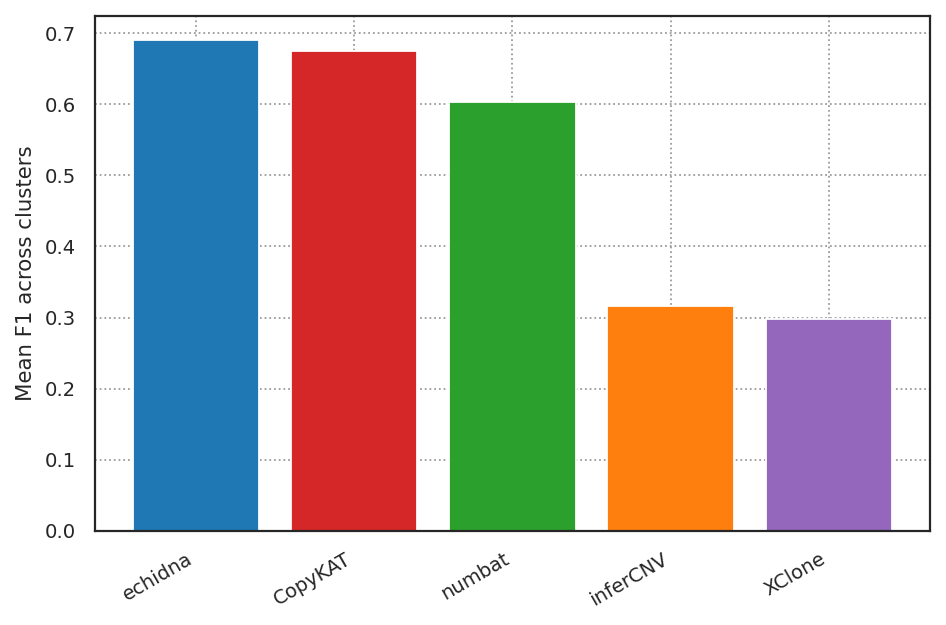

In [130]:
labels  = ['echidna', 'inferCNV', 'numbat', 'CopyKAT', 'XClone']
scores  = [np.mean(f1_ech), np.mean(f1_infercnv),
           np.mean(f1_numbat), np.mean(f1_copykat), np.mean(f1_xclone)]

# sort indices by score, highest → lowest
order = np.argsort(scores)[::-1]

# reorder everything
labels_sorted  = [labels[i]  for i in order]
scores_sorted  = [scores[i]  for i in order]
colors_sorted  = [_COLOR_MAP[l] for l in labels_sorted]

# plot
plt.bar(labels_sorted, scores_sorted, color=colors_sorted)
plt.ylabel("Mean F1 across clusters")
plt.xticks(rotation=30, ha='right')   # optional, improves label readability
plt.tight_layout()

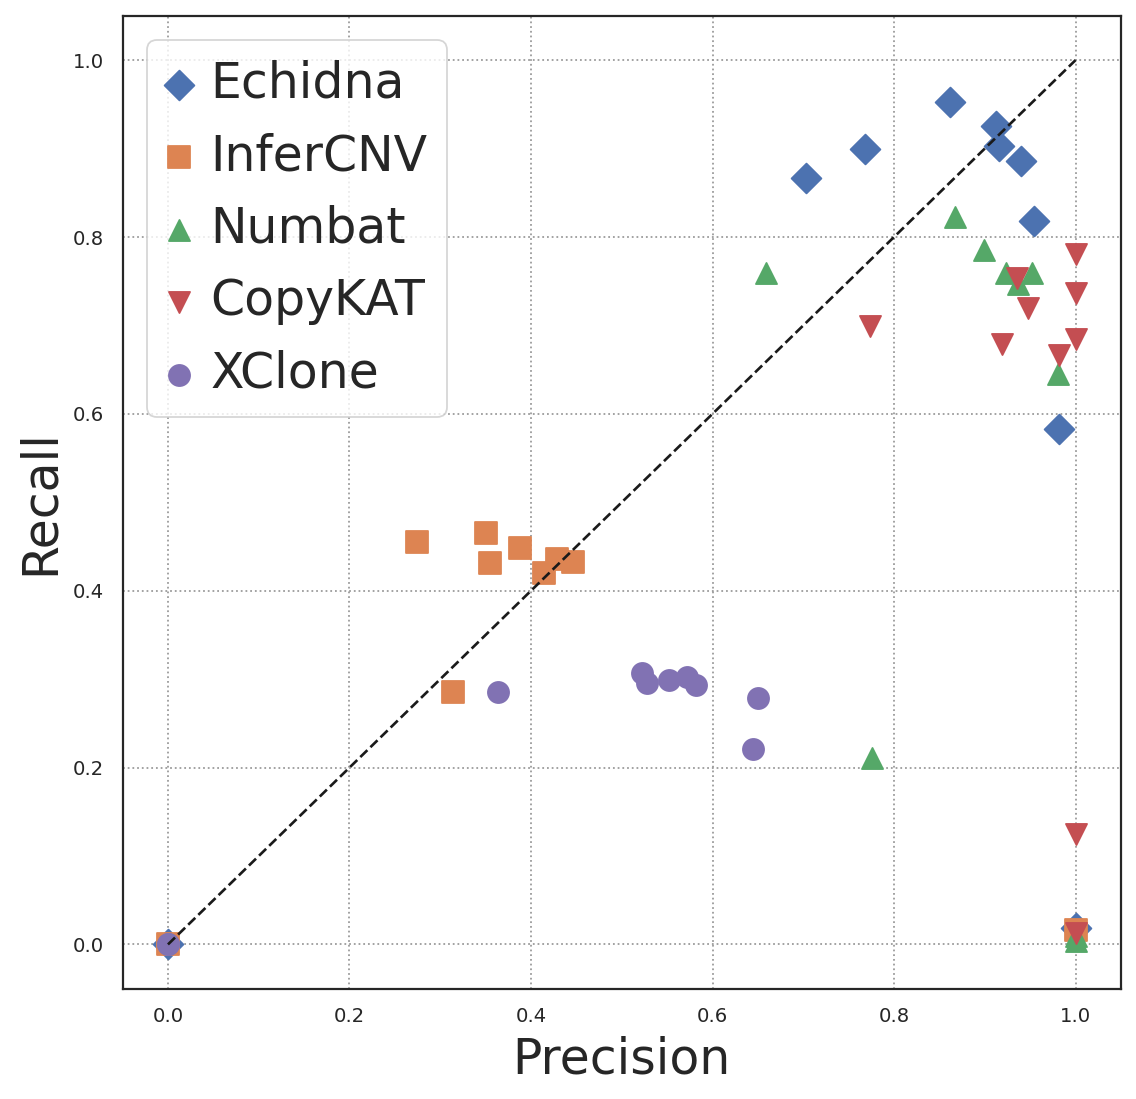

In [131]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(prec_ech, recall_ech, label='Echidna', marker='D', s=90)
ax.scatter(prec_infercnv, recall_infercnv, label='InferCNV', marker='s', s=90)
ax.scatter(prec_numbat, recall_numbat, label='Numbat', marker='^', s=90)
ax.scatter(prec_copykat, recall_copykat, label='CopyKAT', marker='v', s=90)
ax.scatter(prec_xclone, recall_xclone, label='XClone', marker='o', s=90)
ax.plot([0,1],[0,1],'k--')
ax.legend(prop={'size': 22})
ax.set_xlabel('Precision', fontsize=22)
ax.set_ylabel('Recall', fontsize=22)
plt.savefig("tumor2_cna_benchmarking_pr.svg", format="svg", bbox_inches='tight', dpi=300)

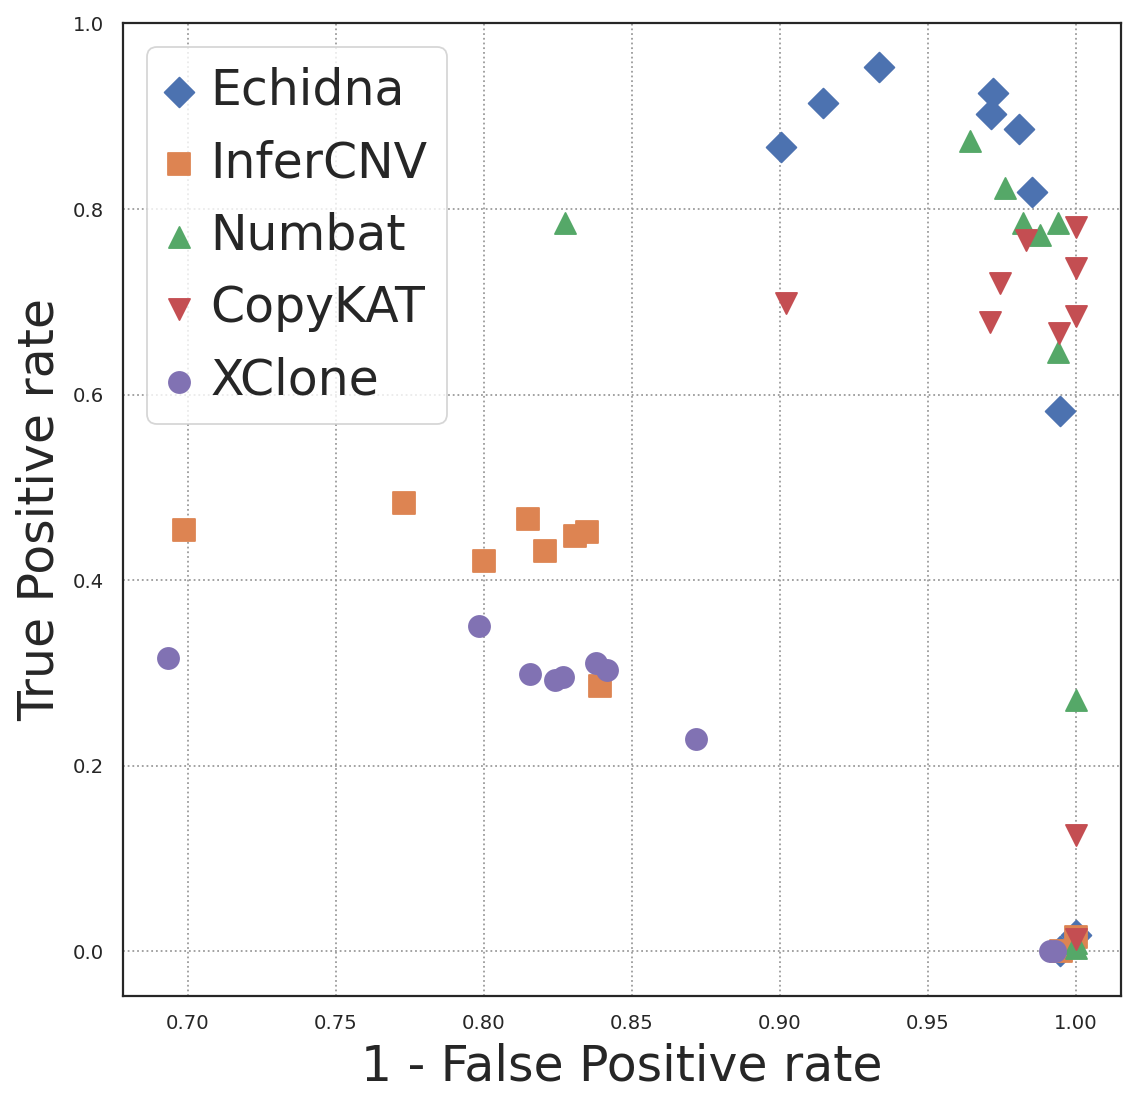

In [132]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(1-fpr_ech, tpr_ech, label='Echidna', marker='D', s=90)
ax.scatter(1-fpr_infercnv, tpr_infercnv, label='InferCNV', marker='s', s=90)
ax.scatter(1-fpr_numbat, tpr_numbat, label='Numbat', marker='^', s=90)
ax.scatter(1-fpr_copykat, tpr_copykat, label='CopyKAT', marker='v', s=90)
ax.scatter(1-fpr_xclone, tpr_xclone, label='XClone', marker='o', s=90)
#ax.plot([0,1],[0,1],'k--')
ax.legend(prop={'size': 22})
ax.set_xlabel('1 - False Positive rate', fontsize=22)
ax.set_ylabel('True Positive rate', fontsize=22)
plt.savefig("tumor2_cna_benchmarking_tprfpr.svg", format="svg", bbox_inches='tight', dpi=300)